##  TimeSerie Analysis - Data Science Specialization module
#### Part 1: Timeserie analysis and forecast of US drugs and pharmacies monthly sales
This notebook intends to illustrate a few techniques and models to analyze TimeSeries and make forecast predictions.

============================

## Let'start by importing all required packages

In [3]:
# data manipulation
import numpy as np
np.set_printoptions(linewidth=1000)
import pandas as pd
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import pickle

# Financial market data handlers/loaders
import yfinance as yf
import mplfinance as mpf
import pandas_datareader.data as web
import pandas_datareader

# Statistics modelization
import statsmodels.tsa.api as tsa
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller, kpss 
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import probplot, moment
# from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess, arma_generate_sample

# package pmdarima (conda install -c conda-forge pmdarima)
from pmdarima.arima import auto_arima

#time series clustering (conda install -c conda-forge tslearn )
from tslearn.generators import random_walks
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# visualization
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('whitegrid')

# time
from datetime import datetime
from datetime import timedelta

# Misc
import warnings
warnings.simplefilter("ignore")

/home/albator/FHNW/TimeSerie-analysis-/venv/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## Let's define some helper functions 

In [4]:
# Helper functions
 
def plot_correlogram(x, lags=None, title=None):
    """ Plot Residuals, QQ-plot of residual and ACF/PACF using the provided Lag value.
        Also performs KPSS, AD-Fuller & Ljung-Box tests to check stationnarity and independence of the TimeSerie.

        Notes: 
        - AD-Fuller test: The null hypothesis of the AD-Fuller test is that there is a unit root, with the alternative that there is no unit root. 
                          If the pvalue is BELOW a critical size (say 5%),  we reject the null i.e there is NO unit root and the TS is stationnary.
        - KPSS test: The null hypothesis for the test is that the data is stationary with the alternative that it is not.
                      If the pvalue is BELOW a critical size (say 5%),  we reject the null i.e the data is not stationnary.                          
        - Ljung-Box test: The null hypothesis of the Ljung-Box test is that residuals are independently distributed.
                          If the pvalue is BELOW a critical size (say 5%),  we reject the null i.e residuals are NOT independent.

    Args:
        x (pandas Series): Time Serie (usually residuals, or 1st difference of TimeSerie)
        lags (int, optional): Desired lag for ACF/PACF analysis and display. Defaults to None.
        title (str, optional): TimeSerie description. Defaults to None.
    """
    warnings.simplefilter("ignore")
    
    # Some parameter definition
    p_crit = 0.05           # confidence level of 5% 
    roll_window = 12        # Number of data points for rolling window (12 as data is usually monthly)

    # First check & initialize the lag value
    if lags is None:
        lags = min(10, int(len(x)/5)) # set an arbitrary value if not defined

    # PerformAD-Full test 
    ADF = adfuller(x)  
    if ADF[1] < p_crit: 
        ADF_text = " => H0 rejected. Data is stationnary."
    else:
        ADF_text = " => Fail to reject H0. Cannot say data is stationnary."

    # Perform Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test 
    KPSS = kpss(x, nlags=lags)  
    if KPSS[1] < p_crit: 
        KPSS_text = " => H0 rejected. Data is not stationnary."
    else:
        KPSS_text = " => Fail to reject H0. Cannot say data is not stationnary."

    # Perform Ljung-Box test (max value for all lags)
    LB = np.max(acorr_ljungbox(x, lags=lags, return_df=False), axis=1)   
    if LB[1] < p_crit: 
        LB_text = " => H0 rejected. Residuals are not independent."
    else:
        LB_text = " => Fail to reject H0. Cannot say residuals are not independently distributed."

    # Define Multiplots figure
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))

    # Top-left plot: Residuals with ad-Fuller and Ljung-box tests 
    x.plot(ax=axes[0][0], title='TimeSerie'+f" (Lag: {lags} data points)")
    x.rolling(roll_window).mean().plot(ax=axes[0][0], c='k', lw=1)             # Rolling window average
    text = (f'AD-Fuller: stat:{ADF[0]:6.2f} p-val:{ADF[1]:6.4f}\n{ADF_text}\n'+
            f'KPSS: stat:{KPSS[0]:6.2f} p-val:{KPSS[1]:6.4f}\n{KPSS_text}')
    axes[0][0].text(x=.02, y=.75, s=text, transform=axes[0][0].transAxes, size = 10)
    axes[0][0].legend(["TimeSerie","Rolling window average"], loc=1)

    # Top-right plot: QQ-plot with the first 4 standardized moments (mean, var, skew, kurtosis)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    text = f'Mean: {mean:>9.2f}\nSD: {np.sqrt(var):>9.2f}\nSkew: {skew:9.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=text, transform=axes[0][1].transAxes)

    # Bottom-left plot:  Auto Correlation Function 
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    text = (f'Ljung-box: stat:{LB[0]:6.2f} p-val:{LB[1]:6.4f}\n{LB_text}')    
    axes[1][0].text(x=.02, y=.9, s=text, transform=axes[1][0].transAxes, size = 10)
    axes[1][0].set_xlabel('Lag')

    # Bottom-right plot: Partial Auto Correlation Function 
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1], method='ywm')
    axes[1][1].set_xlabel('Lag')

    # Adjust overall layout
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

def TimeSerie_OLS (Y, summary = True, plot = True, CI=True):
    """Runs an OLS on a Pandas time Series using the Series index as independent variable

    Args:
        Y (pandas Series): Time Serie data to regress
        summary (bool, optional): Switch for ploting the OLS model summary. Defaults to True.
        plot (bool, optional): Switch to plot the training data and linear model. Defaults to True.

    Returns:
        floats: a & b model parameters
    """
    
    y_train = Y.squeeze().dropna()
    X_train = y_train.index.to_julian_date()

    X_train = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()  
    a, b = model.params

    if CI:
        ConfInt = model.conf_int(alpha=0.05, cols=None)
    else:
        ConfInt = None

    if summary: 
        print(model.summary())  

    if plot:      
        plt.scatter(y_train.index, y_train, alpha=0.3)        
        y_predict = a + b * X_train[:,1]
        plt.plot( y_train.index,y_predict, linewidth=3, color="red")
        
    return a,b,ConfInt

def plot_series(series, axes=None):
    """_summary_

    Args:
        series (_type_): _description_
        axes (_type_, optional): _description_. Defaults to None.
    """
    if axes == None:
        plt.plot(series, color='red')
        for year in range(data_diff1_noseason.index[0].year, data_diff1_noseason.index[-1].year):
            plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)
    else:
        axes.plot(series, color='red')
        for year in range(data_diff1_noseason.index[0].year, data_diff1_noseason.index[-1].year):
            axes.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

    

## Let's now load some TimeSerie data 

The python library "pandas-datareader" bundles together many different APIs from various libraries to read TimeSeries data.   
(see a list of Internet sources available to Pandas-Reader there: https://pandas-datareader.readthedocs.io/en/latest/readers/index.html)   

Two TimeSeries data sources are of particular interest:    
1- Yahoo Finance: provides historical data on stocks, indexes, etc  (see available stocks there: https://finance.yahoo.com/lookup/)   
2- FRED (Federal Reserve Economic Data) for various US economic KPIs  (see official website: https://fred.stlouisfed.org/)

TimeSerie data shape: (361,)

DATE
1992-01-01    6358
1992-02-01    6284
1992-03-01    6420
1992-04-01    6573
Name: MRTSSM44611USN, dtype: int64
DATE
2021-12-01    30120
2022-01-01    27297
Name: MRTSSM44611USN, dtype: int64


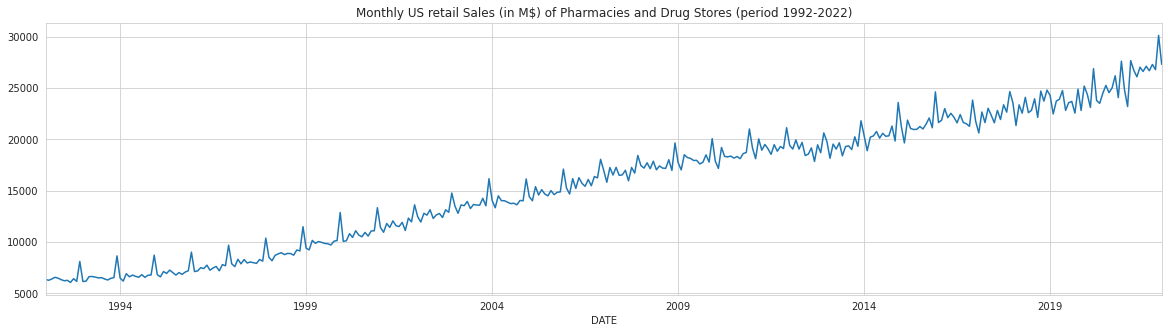

In [5]:
# From the course
# data = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv",header=0, index_col=0)

# Various TimeSerie datasets
#
# symbol, module, start, end,stock_name = "TOTALSA", "fred", "Total US Vehicles sales (monthly)"
# symbol, module, start, end, stock_name = "UNRATE", "fred", 1948, 2022, "US  Unemployment Rate (period 1948-2022)"
# symbol, module, start, end, stock_name = "LMUNRRTTCHM156N", "fred", 1960, 2022, "% registered Unemployment Rate for Switzerland (period 1960-2022)"
# symbol, module, start, end, stock_name = "QCHR628BIS", "fred", 1970, 2022, "Real Residential Property Prices for Switzerland, indexed on 2010 (period 1970-2022)"
symbol, module, start, end, stock_name = "MRTSSM44611USN", "fred", 1992, 2022, "Monthly US retail Sales (in M$) of Pharmacies and Drug Stores (period 1992-2022)"


# We load the data as a Pandas DataFrame or Series (depending on data type or source)
data = web.DataReader(symbol, module , start=start, end=end).squeeze().dropna()
# print (data.info())
print(f"TimeSerie data shape: {data.shape}")
# print(f"TimeSerie data type: {type(data)}")

# Print some info
print()
print(data.head(4))
print(data.tail(2))

# Check if data is Historical (Dataframe) or Real-Time (Series), plot the TimeSerie, use "Closing price"
# Note: Historical data corresponds to multiple Series with Date, Open Price, High Price, Low Price, Closing Price & Volume
if isinstance(data, pd.DataFrame):
    mpf.plot(data,type='line',volume=True, figsize=(20,5), title=stock_name)
    data = data.Close.squeeze().dropna()
else:
    data.plot(figsize=(20, 5), title=stock_name)
    plt.show()

# Save data for later recovery
data.to_csv(stock_name, header=False, index=False)

## Overview of TimeSerie analysis:
- We often need to analysis TimeSeries to "better understand" the data or make forecast predictions.   
- For that purpose it it is useful to model the TimeSerie data.
- Most Timeseries models work under the assumption that the underlying data is stationary.   
- Unfortunatelly most Timeseries will not be stationary and the trends present in the data will have to be identified and removed.   
- After the trends are removed one can apply advanced modeling techniques while maintaining the valuable knowledge of the separated trends, which can be re-used later.
- There are a few options when it comes to removing trends: "naive" decomposition, transformation of the data, removing a rolling statistic, and differencing, etc.

### We will now look into a few of those options:   

Option 1: "Naive" decomposition, modelization of the stationnary residuals with an ARMA model, forecast of each component and recomposition of the forecast TimeSerie.   

Option 2: Transform the TimeSerie to make it stationnary using differentiation and model it using an ARMA model.    

Option 3: Transform the TimeSerie by removing a rolling average and model it using an ARMA model.    

Option 4: Model the original TimeSerie using an ARIMA model which will consider the trend component.    

Option 5: Model the original TimeSerie with an Auto-ARIMA model which can take into account both the trend and the seasonal components.

## Option 1: "Naive" TimeSerie decomposition, ARMA modelization, components forecast

The library "statsmodels.tsa.seasonal_decompose" offers a "naive" decomposition function.       
Results are obtained by first estimating the trend by applying a convolution filter to the data.   
The trend is then removed from the series and the average of this de-trended series for each period is the returned seasonal component.   
   
Notes:    
1- The period for the seasonal component computation might need to be adjusted depending on the data.  
2- Similarly the decomposition model may be adjusted depending whether the TimeSerie contributions are additive or multiplicative.

### Option 1 step 1: "Naive" decomposition of the TimeSerie into Trend, Seasonal and Residuals components

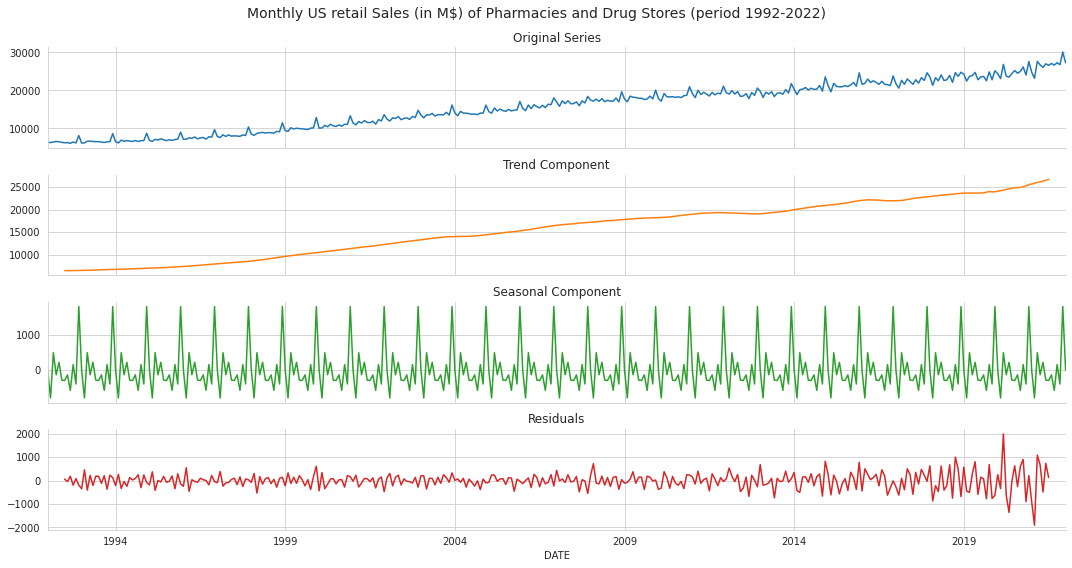

In [6]:
# Split components
# components = tsa.seasonal_decompose(data, model='multiplicative', period=12)
components = tsa.seasonal_decompose(data, model='additive', period=12)

# Aggregate component to new DataFrame
data_decomposed = (data.to_frame('Original')
                        .assign(Trend=components.trend)
                        .assign(Seasonality=components.seasonal)
                        .assign(Residual=components.resid) )

# Plot components
data_decomposed.plot(subplots=True, figsize=(15, 8), title=['Original Series', 'Trend Component', 'Seasonal Component','Residuals'], legend=False)
plt.suptitle(stock_name, fontsize=14)
sns.despine()
plt.tight_layout()
plt.subplots_adjust(top=.91);

COMMENTS:   
- The trend and yearly seasonal components from the TimeSerie are non negligible.   
- The type of model decomposition type (additive vs multiplicative) has a large impact on the residuals.  
- Using the multiplicative decomposition will remove all skew and kurtosis but leave some of the seasonal component in the residuals.   
- Using the additive decomposition will completely remove the seasonal component but leave some skew and kurtosis in the residuals.   

### Option 1 step 2: Let's evaluate the ACF & PACF of the residuals. 
We plot a correlogram which conveniently displays a QQ-plot and the ACF and PACF of the residuals and evaluate the AD-Fuller & Ljung-Box tests to check for stationnarity and independence of the residuals.

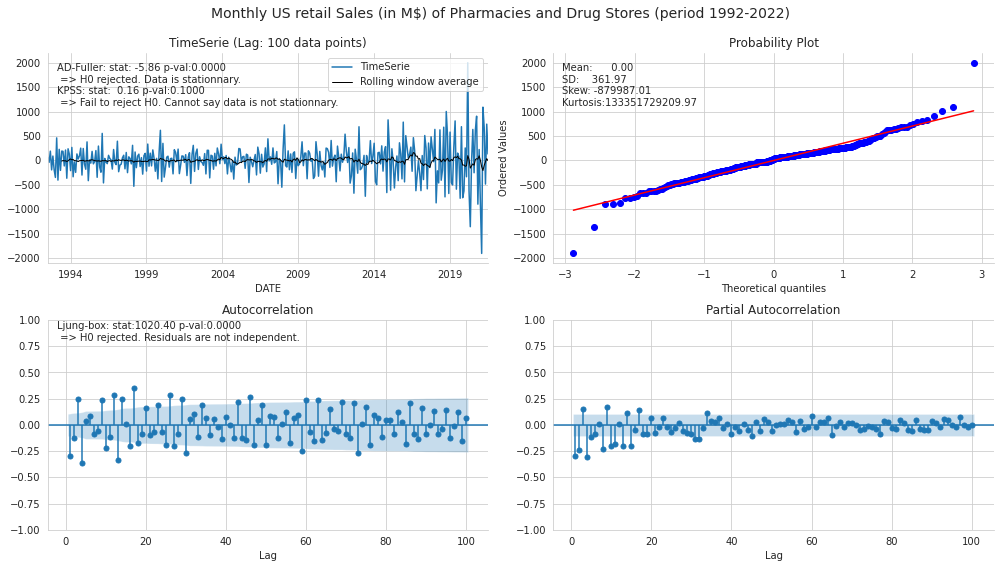

In [7]:
# Call to helper function plot_correlogram
plot_correlogram(data_decomposed.Residual.squeeze().dropna(), lags=100, title=stock_name)

COMMENTS:   
- Both the ADF and KPSS tests show the residuals are stationary.   
- The QQ-plot shows the residuals are almost normally distributed with hearvier tails at large Q-values.    
- The ACF shows small contributions up to high lag values (~17).   
- Similarly the PACF shows small contributions up to lag 17.   
- Besides the heteroskedacity assumption of stationarity is slightly violated as fluctuations seem to increase after 2014 onwards. This will undermine the modelization and forecast. 

### Option 1 step 3: Modelisation of the residuals with an ARMA model
We saw previously that the ACF and PACF had contributions up to lag 17 so let's try and fit an ARMA model with this order.  

In [8]:
# Split the data into training and test sets
TEST_SIZE = 12
residuals = data_decomposed.Residual.squeeze().dropna()
train, test = residuals.iloc[:-TEST_SIZE], residuals.iloc[-TEST_SIZE:]

# Create and fit an ARMA model with order(17,17)
ARIMA_model = ARIMA(train, order=(17,0,17))
# ARIMA_model = ARIMA(train, order=(3,0,3))
ARIMA_model_fit = ARIMA_model.fit()

print (ARIMA_model)
print (ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Residual   No. Observations:                  337
Model:               ARIMA(17, 0, 17)   Log Likelihood               -2318.917
Date:                Mon, 25 Jul 2022   AIC                           4709.833
Time:                        20:44:50   BIC                           4847.356
Sample:                    07-01-1992   HQIC                          4764.648
                         - 07-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1509      2.329     -0.923      0.356      -6.716       2.415
ar.L1          0.0782      0.214      0.365      0.715      -0.342       0.498
ar.L2         -0.3514      0.200     -1.755      0.0

Comments:   
- Below is a summary of a few trials:   
ARMA( 1, 1) => LL=-2394 AIC=4797 BIC=4812,  no confidence on AR coef   
ARMA( 2, 2) => LL=-2391 AIC=4794 BIC=4816,  no confidence on MA2 coef   
ARMA( 3, 3) => LL=-2373 AIC=4762 BIC=4792 , no confidence on all MA coefs   
ARMA(17,17) => LL=-2319 AIC=4710 BIC=4847, confidence only on higher AR coefs 13 & 17, MA coef lag 17

- Fitting a high order ARMA model results in better fitting the data (higher LogLikelihood, lower AIC) but results in most AR & AM lag coefficients being non-significant and runs the risk of overfitting (higher BIC).   
- Fitting a low order ARMA model on the other hand results in AR & AM lag coefficients being significant and less overfitting (lower BIC) but overall a worst fit (lower LL, higher AIC).   
- Overall it is not trivial to model the residuals using an ARMA model after removing the trend and seasonal components. The process is manual and a bit tedious.

Let's check the fitness of our model vs the training data

MAPE 1.5331938464846584
MAE 163.2063543590997
RMSE:  231.26558495572058


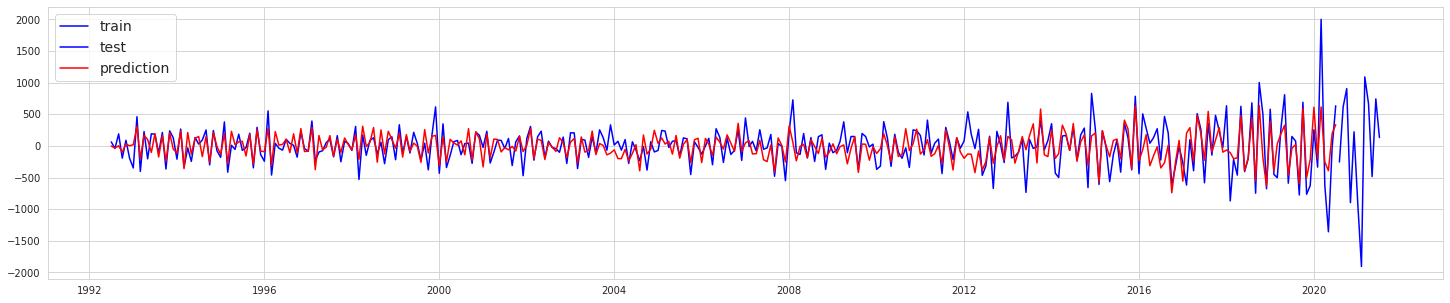

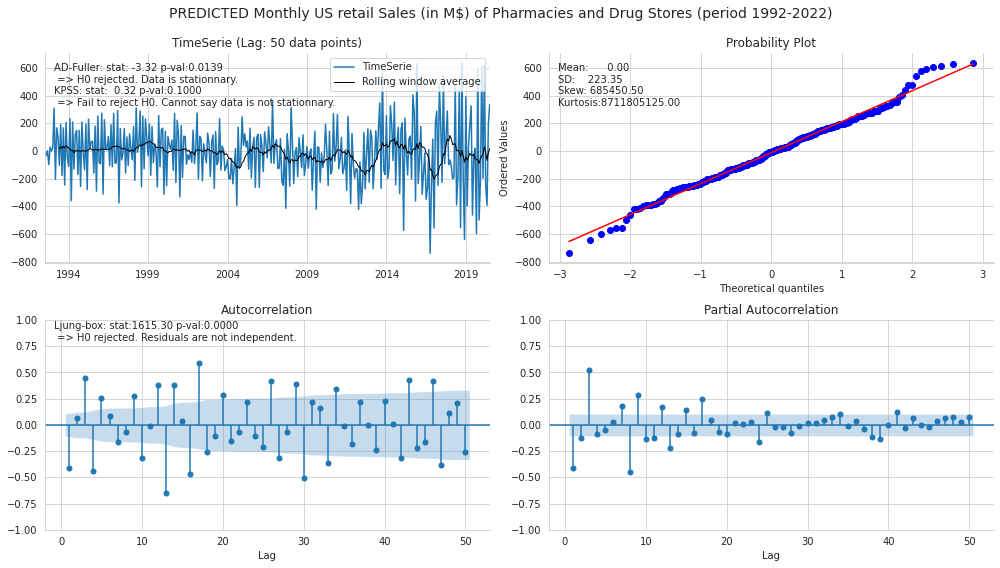

In [9]:
## In-sample prediction (on training data)
ARIMA_model_prediction = ARIMA_model_fit.predict(start=train[:1].index.format()[0], end=train[-1:].index.format()[0]) # works

print("MAPE",mean_absolute_percentage_error(train, ARIMA_model_prediction))
print("MAE",mean_absolute_error(train, ARIMA_model_prediction))
print("RMSE: ",(mean_squared_error(train, ARIMA_model_prediction))**0.5)

fig, ax1 = plt.subplots(1, 1, figsize=(25, 5))
ax1.plot(train, color="blue")
ax1.plot(test, color="blue")
ax1.plot(ARIMA_model_prediction, color="red")
# ax1.fill_between(ARIMA_model_prediction.index, cf[0], cf[1],color='grey',alpha=.3)
ax1.legend(["train", "test", "prediction"], prop={"size":14})

plot_correlogram(ARIMA_model_prediction, lags=50, title="PREDICTED "+stock_name)

Comments:   
- The ARMA(17,17) prediction of the US retail Sales residuals matches pretty well the original TimeSerie residuals.   
- Both the ACF & PACF of the ARMA model have close similarities with the original TimeSerie residuals.    

### Option 1 step 4: Let's now try and make an out of sample prediction (i.e a forecast) of the residuals over the test data (i.e the next time period)

<class 'pandas.core.series.Series'>
(18,)


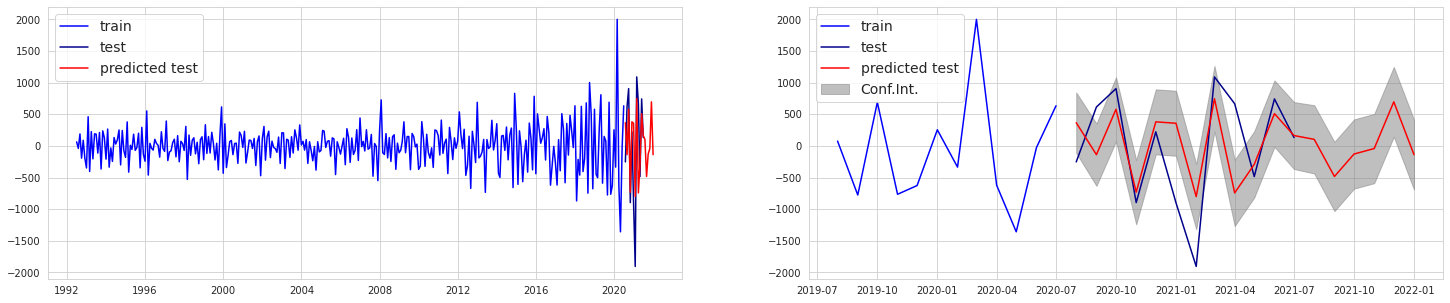

In [10]:
# Forecasting

ARIMA_model_prediction = ARIMA_model_fit.forecast(TEST_SIZE+6) # works
cf = ARIMA_model_fit.get_forecast(TEST_SIZE+6).conf_int(alpha=0.05)
print(type(cf.iloc[:, 0]))
print(ARIMA_model_prediction.shape)

# Plotting forecast and confidence interval 
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(25, 5))
ax1.plot(train, color="blue")
ax1.plot(test, color="darkblue")
ax1.plot(ARIMA_model_prediction, color="red")
# ax1.fill_between(ARIMA_model_prediction.index, cf[0], cf[1],color='grey',alpha=.3)
ax1.legend(["train", "test", "predicted test"], prop={"size":14})
ax2.plot(train[-12:], color="blue")
ax2.plot(test, color="darkblue")
ax2.plot(ARIMA_model_prediction, color="red")
ax2.fill_between(cf.index, cf.iloc[:, 0], cf.iloc[:, 1], color='grey', alpha=.5)
ax2.legend(["train", "test", "predicted test", "Conf.Int."], prop={"size":14})

Comments:   
- The forecast of the next month's Sales is fairly good compared to the test data of the original TimeSerie.   
- The model certinly captures the up-and-down trends and the forecast values are wthin the 5% confidence interval for most points.    


### Option 1 step 5: Trend modelization and forecast

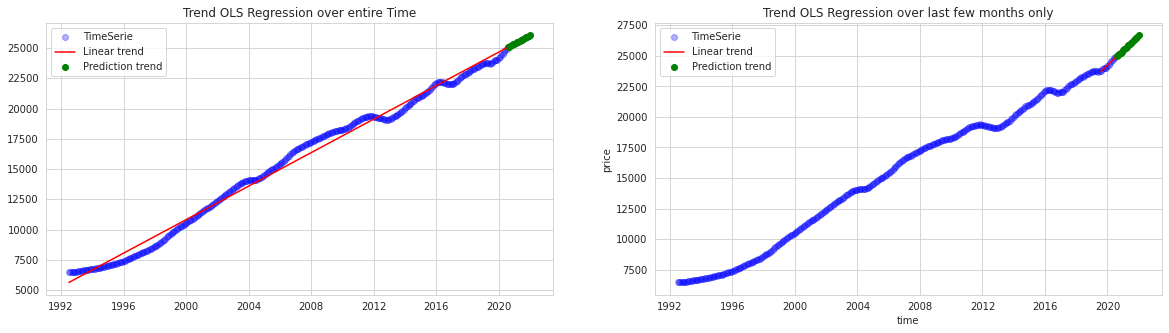

In [11]:
# Prepare the plot
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# The last 6 months of the TimeSerie decomposition cannot be evaluated but we want to include them in our forecast and compare the predictions to the original TimeSerie.  
predict_idx = TEST_SIZE + 6

# OLS estimation over ENTIRE time
TS_trend_train = data_decomposed.Trend.dropna().squeeze()[:-TEST_SIZE]
a,b,_ = TimeSerie_OLS (TS_trend_train, False, False)
Trend_forecast_train = pd.Series(a + b * TS_trend_train.index.to_julian_date())
Trend_forecast = pd.Series(a + b * data[-predict_idx:].index.to_julian_date(), index=data[-predict_idx:].index)
# Plot trend ad linear model
ax1.scatter(TS_trend_train.index, TS_trend_train, alpha=0.3, color="blue") 
ax1.plot(TS_trend_train.index, Trend_forecast_train, color="red")
ax1.scatter(Trend_forecast.index, Trend_forecast, color="green")
plt.xlabel('time')
plt.ylabel('price')
ax1.title.set_text('Trend OLS Regression over entire Time')
ax1.legend(["TimeSerie", "Linear trend", "Prediction trend"])

# OLS estimation over LAST 1.5 YEAR (12 months from TEST dataset + 6 months from decomposition "padding")
idx = TEST_SIZE + 12
TS_trend_1year = data_decomposed.Trend.dropna().squeeze()[-idx:-TEST_SIZE]
a,b,CI_trend = TimeSerie_OLS (TS_trend_1year, False, False)
Trend_forecast_1year = pd.Series(a + b * TS_trend_1year.index.to_julian_date())
Trend_forecast = pd.Series(a + b * data[-predict_idx:].index.to_julian_date(), index=data[-predict_idx:].index)
# Plot trend and linear model
ax2.scatter(TS_trend_train.index, TS_trend_train, alpha=0.3, color="blue") 
ax2.plot(TS_trend_1year.index, Trend_forecast_1year, color="red")
ax2.scatter(Trend_forecast.index, Trend_forecast, color="green")
plt.xlabel('time')
plt.ylabel('price')
ax2.title.set_text('Trend OLS Regression over last few months only')
ax2.legend(["TimeSerie", "Linear trend", "Prediction trend"])

plt.show()



Comments:   
- As illustrated above, even though we can estimate the trend by linear regression, deciding whether to use the last few months or the entire dataset in order to make a forecast is somewhat arbitrary and subjective to our belief in the future.
- We will continue with the trend based on the latestdata evolution of the sales (and not the entire available TimeSerie).   

### Option 1 step 6: Seasonal component modelisation
The seasonal component is readily available from the decomposition.

<AxesSubplot:xlabel='DATE'>

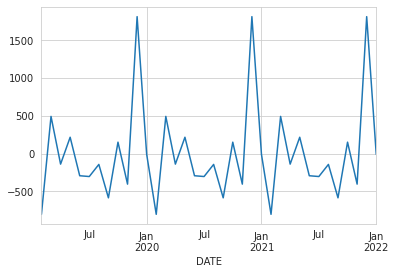

In [12]:
# Seasonality is based on 12 months but we are forcasting 18 months (as decomposition has a 6 months "padding")
seasonal_forecast = data_decomposed.Seasonality[-predict_idx:]
# print(seasonal_forecast)

# Let's plot the 3 last seasons for illustration
data_decomposed.Seasonality[-36:].plot()

### Option 1 step 7: TimeSerie forecast recomposition   
Let's now recompose the forecast for the residual+trend+seasonal components and compare it to the original TimeSerie.


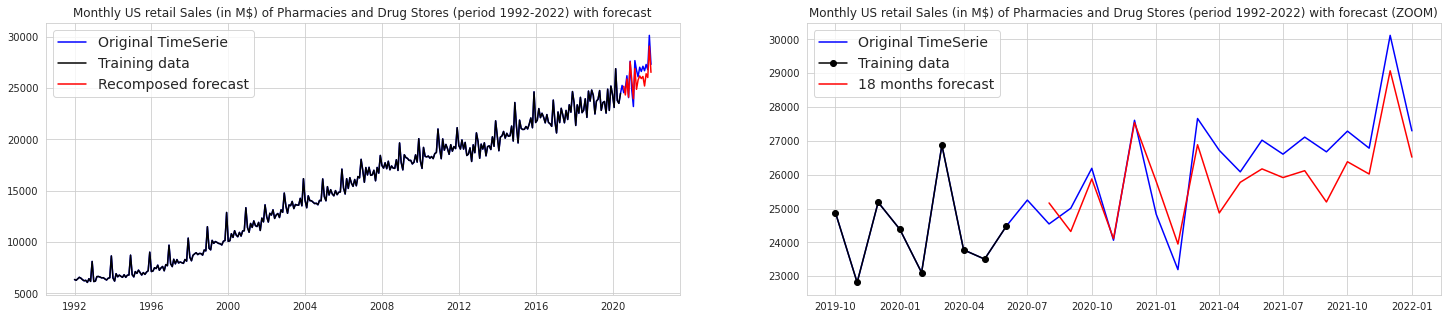

In [13]:
# Recomposition
TS_forecast = ARIMA_model_prediction + Trend_forecast + seasonal_forecast

#  Plotting forecast and confidence interval 
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(25, 5))
ax1.plot(data, color="blue")
ax1.plot(data.index[:-19], data.iloc[:-19], color="black")
ax1.plot(TS_forecast, color="red")
ax1.legend(["Original TimeSerie", "Training data", "Recomposed forecast"], prop={"size":14})
ax1.title.set_text(stock_name+" with forecast")

ax2.plot(data[-28:], color="blue")
ax2.plot(data.index[-28:-19], data.iloc[-28:-19], color="black", marker = 'o')
ax2.plot(TS_forecast, color="red")
ax2.legend(["Original TimeSerie", "Training data", "18 months forecast"], prop={"size":14})
ax2.title.set_text(stock_name+" with forecast (ZOOM)")

Comments:    
- The approach taken in option 1 whereby the TimeSerie is decomposed, each component forecasted invidually and then recomposed works surprisingly well and produces relevant results.   
- The method is however manual, tedious and somewhat arbitrary to the choices made in modeling the trand and residuals.   
- Besides many models can now direclty capture trend and seasonal components as we will now see.   

## Option 2: TimeSerie transformation using differentiation, modelization using an ARMA model.    
### Option 2 step 1: TimeSerie transformation using differentiation
As mentioned TimeSerie differentiation can be used to reach stationarity.   
Higher order differentiation may sometimes be required to reach stationarity.  
We investigate below the first 2 order of differentiation and plot the corresponding correlograms  

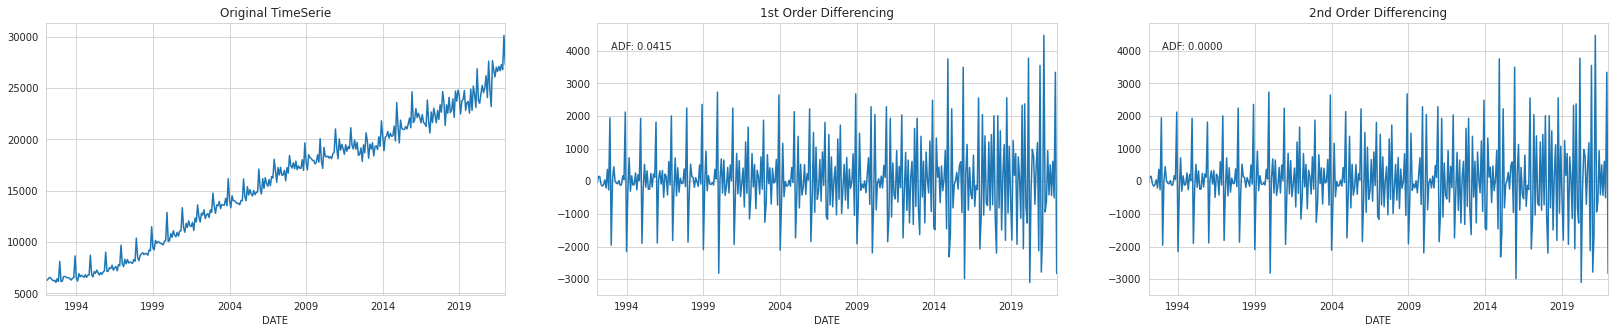

In [14]:
# Calculating log, diff and log-diff of the TimeSerie
data_diff1 = data.diff().dropna()
data_diff2 = data.diff().diff().dropna()

# Plot TimeSerie differentiation
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 5))
data.plot(ax=axes[0], title="Original TimeSerie")
data_diff1.plot(ax=axes[1], title="1st Order Differencing")
axes[1].text(x=.03, y=.9, s=f'ADF: {adfuller(data_diff1.dropna())[1]:.4f}', transform=axes[1].transAxes)
data_diff1.plot(ax=axes[2], title="2nd Order Differencing")
axes[2].text(x=.03, y=.9, s=f'ADF: {adfuller(data_diff2.dropna())[1]:.4f}', transform=axes[2].transAxes)
fig.align_ylabels(axes)
plt.show()


Comments: 
- According the AD-Fuller test the 1st difference of the data is enough to produce a stationnary TimeSerie with a 5% confidence.  
- A 2nd order difference of the TimeSerie does improve further the confidence on stationnarity but is not required.   
- Let's now vizualize the ACF & PACF of the 1st difference.  

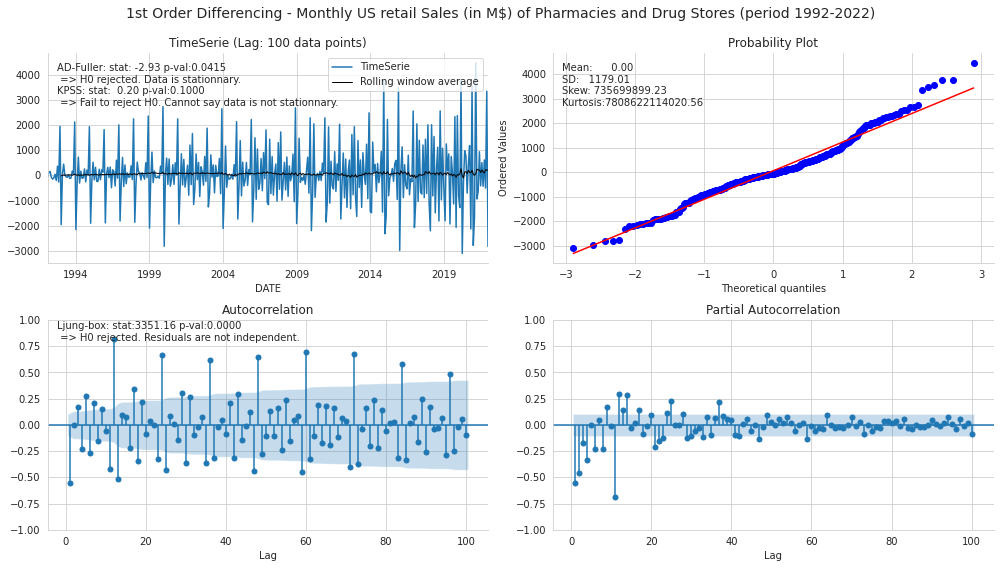

In [15]:
# Plot
plot_correlogram(data_diff1.squeeze().dropna(), lags=100, title="1st Order Differencing - "+stock_name)

### Option 2 step 2: TimeSerie transformation using log and differentiation
When the TimeSerie has an expentional trend and / or exponentially increasing fluctions it may be beneficial to transform the data using the log function.  
Let's briefly check if it makes an improvement to the TimeSerie analysis in the our case.  

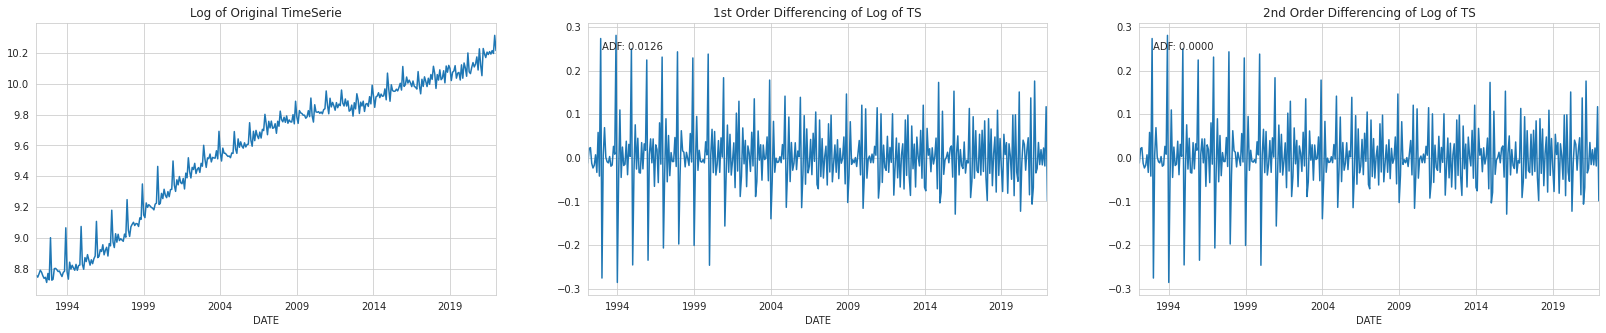

In [16]:
# Calculating log and log-diff of the TimeSerie

data_log = np.log(data)
data_diff1_log = data_log.diff().dropna()
data_diff2_log = data_log.diff().diff().dropna()

# Plot TimeSerie log transformation
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 5))
data_log.plot(ax=axes[0], title="Log of Original TimeSerie")
data_diff1_log.plot(ax=axes[1], title="1st Order Differencing of Log of TS")
axes[1].text(x=.03, y=.9, s=f'ADF: {adfuller(data_diff1_log.dropna())[1]:.4f}', transform=axes[1].transAxes)
data_diff1_log.plot(ax=axes[2], title="2nd Order Differencing of Log of TS")
axes[2].text(x=.03, y=.9, s=f'ADF: {adfuller(data_diff2_log.dropna())[1]:.4f}', transform=axes[2].transAxes)
fig.align_ylabels(axes)
plt.show()

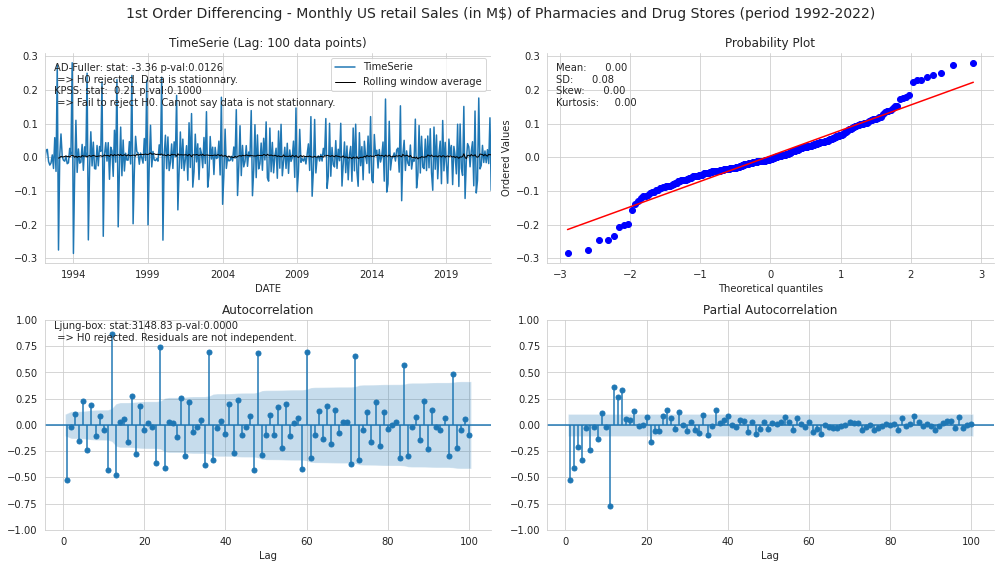

In [17]:
# Plot
plot_correlogram(data_diff1_log.squeeze().dropna(), lags=100, title="1st Order Differencing - "+stock_name)

Comments:   
- In our case using the log-transformation prior to differentiation helps a little bit with the stationnarity of the 1st difference (ADF test confidence improved).  
- It does not however provide a major improvement as the Trend does not follow an exponention increase and similarly the fluctuations do not increases exponentially.


### Option 2 step : Removal of seasonality

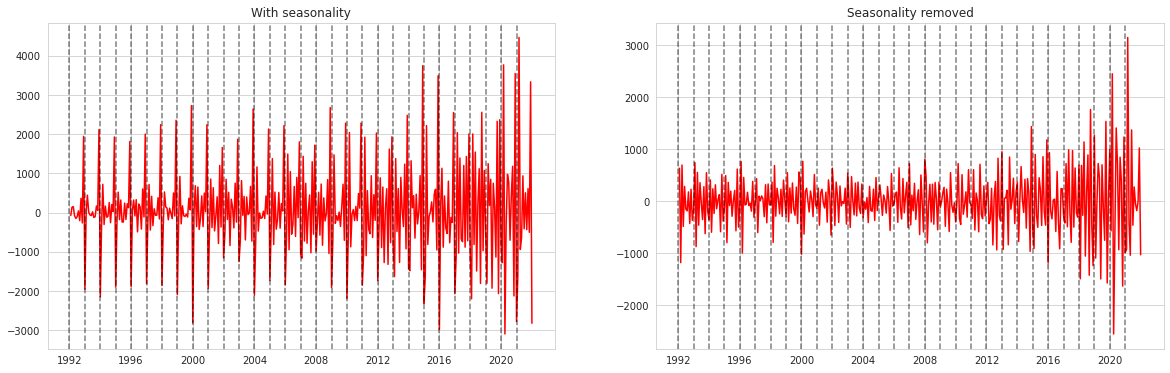

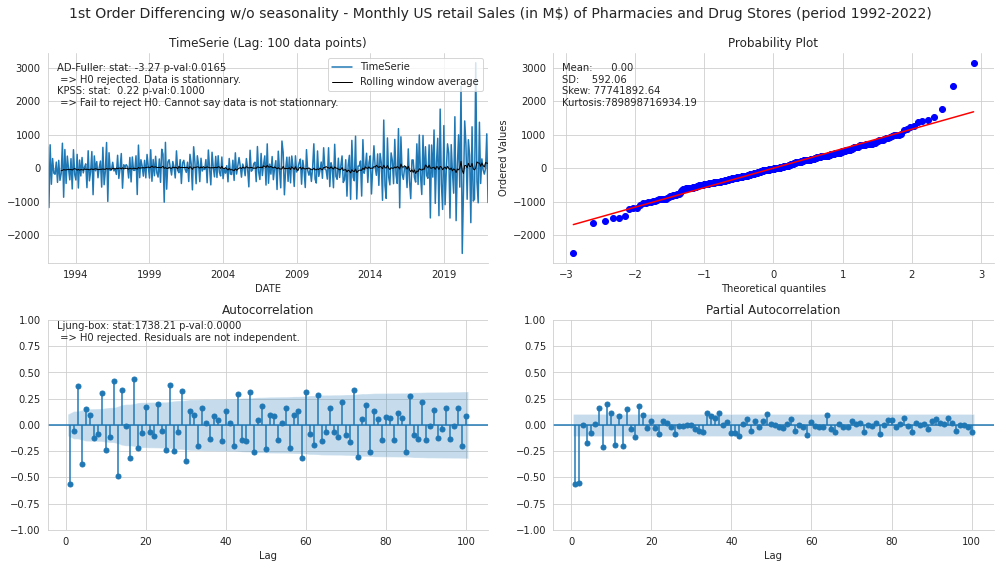

In [18]:
# Calculate monthly averages
month_avgs = data_diff1.groupby(data_diff1.index.month).mean()
data_diff1_month_avg = data_diff1.index.map(lambda d: month_avgs.loc[d.month])

# Remove monthly averages
data_diff1_noseason = data_diff1 - data_diff1_month_avg

# Plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,6))
plot_series(data_diff1, axes = ax1)
ax1.set_title("With seasonality")
plot_series(data_diff1_noseason, axes = ax2)
ax2.set_title("Seasonality removed")
plt.show()

# Plot
plot_correlogram(data_diff1_noseason.squeeze().dropna(), lags=100, title="1st Order Differencing w/o seasonality - "+stock_name)

Comments:   
- The seasonal component has been removed.   
- The ACF & PACF of the 1st different w/o seasonality suggests a ARMA(2,2) model might be sufficient to model the TimeSerie.   

### Option 2 step : TimeSerie difference modelization and forecast

In [19]:
# Split the data into training and test sets
TEST_SIZE = 30
train, test = data_diff1_noseason.iloc[:-TEST_SIZE], data_diff1_noseason.iloc[-TEST_SIZE:]

# Create and fit an ARMA model 
ARIMA_model = ARIMA(train, order=(17,0,17))
ARIMA_model_fit = ARIMA_model.fit()

print (ARIMA_model)
print (ARIMA_model_fit.summary())



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  330
Model:               ARIMA(17, 0, 17)   Log Likelihood               -2311.018
Date:                Mon, 25 Jul 2022   AIC                           4694.036
Time:                        20:45:11   BIC                           4830.803
Sample:                    02-01-1992   HQIC                          4748.590
                         - 07-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.1296      8.931     -0.574      0.566     -22.635      12.376
ar.L1         -0.0230      0.577     -0.040      0.968      -1.154       1.109
ar.L2          0.3581      0.572      0.626      0.5

Comments:   
- Let's now predit the train data

MAPE 2.026109608323359
MAE 198.91340120973223
RMSE:  266.5822968211122


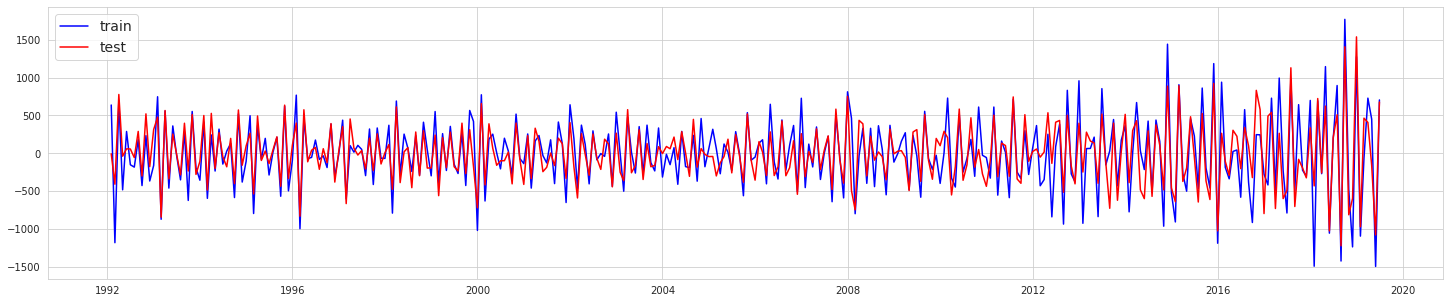

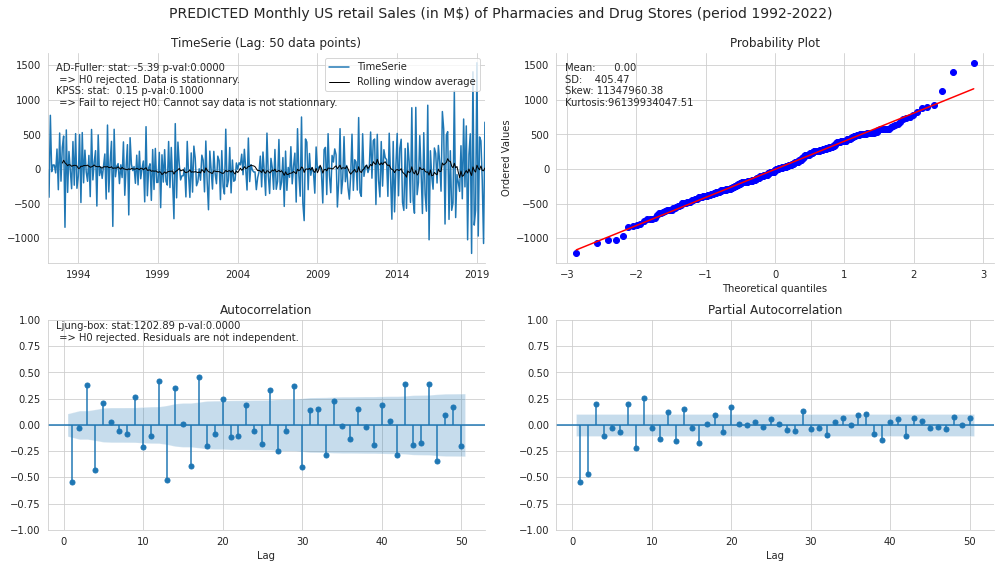

In [20]:
## In-sample prediction (on training data)
ARIMA_model_prediction = ARIMA_model_fit.predict(start=train[:1].index.format()[0], end=train[-1:].index.format()[0]) # works

print("MAPE",mean_absolute_percentage_error(train, ARIMA_model_prediction))
print("MAE",mean_absolute_error(train, ARIMA_model_prediction))
print("RMSE: ",(mean_squared_error(train, ARIMA_model_prediction))**0.5)

fig, ax1 = plt.subplots(1, 1, figsize=(25, 5))
ax1.plot(train, color="blue")
ax1.plot(ARIMA_model_prediction, color="red")
# ax1.fill_between(ARIMA_model_prediction.index, cf[0], cf[1],color='grey',alpha=.3)
ax1.legend(["train", "test", "prediction"], prop={"size":14})

plot_correlogram(ARIMA_model_prediction, lags=50, title="PREDICTED "+stock_name)


### Option 2 step : Forecasting on the 1st difference ARMA model 

<class 'pandas.core.series.Series'>
(30,)


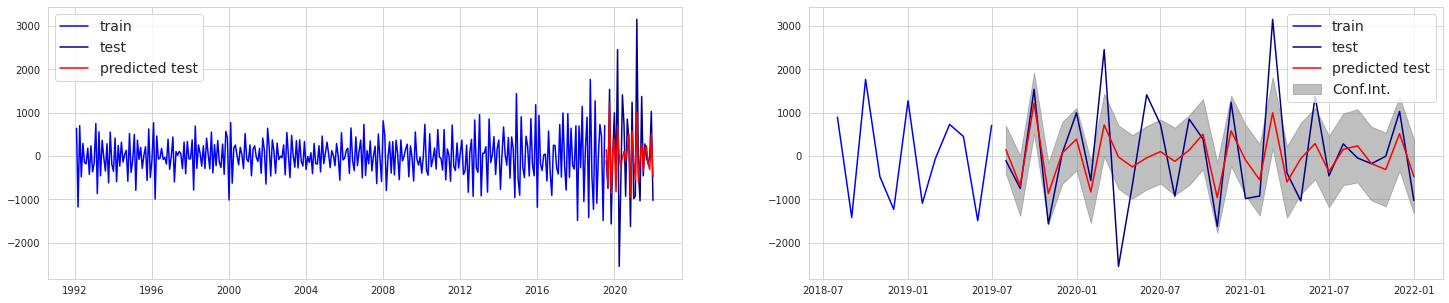

In [21]:
# Forecasting
ARIMA_model_prediction = ARIMA_model_fit.forecast(TEST_SIZE) 
cf = ARIMA_model_fit.get_forecast(TEST_SIZE).conf_int(alpha=0.05)
print(type(cf.iloc[:, 0]))
print(ARIMA_model_prediction.shape)

# Plotting forecast and confidence interval 
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(25, 5))
ax1.plot(train, color="blue")
ax1.plot(test, color="darkblue")
ax1.plot(ARIMA_model_prediction, color="red")
# ax1.fill_between(ARIMA_model_prediction.index, cf[0], cf[1],color='grey',alpha=.3)
ax1.legend(["train", "test", "predicted test"], prop={"size":14})
ax2.plot(train[-12:], color="blue")
ax2.plot(test, color="darkblue")
ax2.plot(ARIMA_model_prediction, color="red")
ax2.fill_between(cf.index, cf.iloc[:, 0], cf.iloc[:, 1], color='grey', alpha=.5)
ax2.legend(["train", "test", "predicted test", "Conf.Int."], prop={"size":14})

### Option 2 step : TimeSerie integration and recomposition

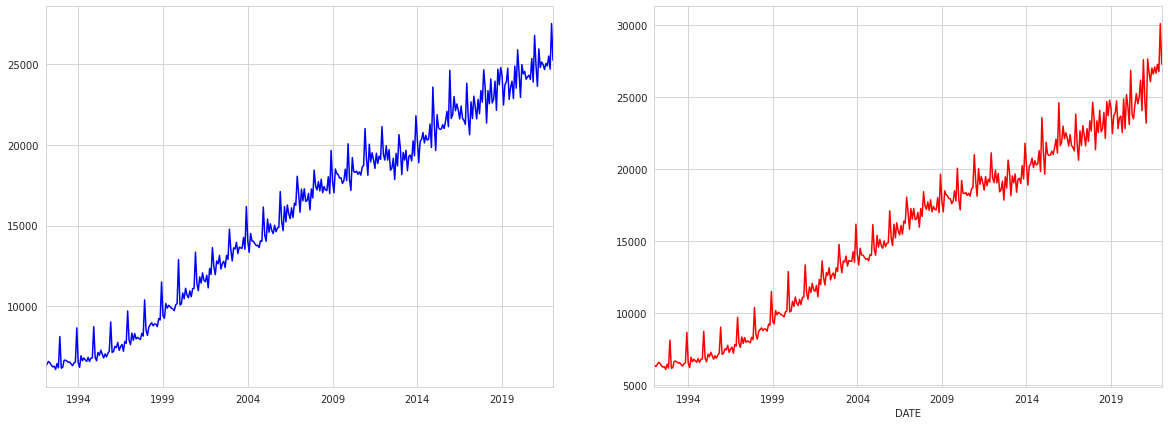

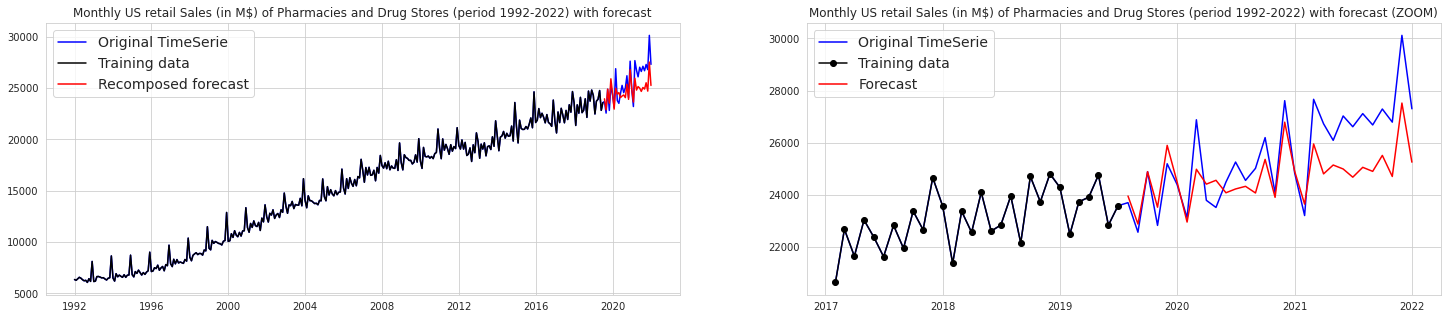

In [22]:
# Recomposition 
new_serie = pd.concat([data_diff1[:-TEST_SIZE], ARIMA_model_prediction+ data_diff1_month_avg[-TEST_SIZE:]], axis=0)

# Integrate the differentiated TimeSerie 
data_diff1_cumsum = new_serie.cumsum() + data[0]

# Comparing the original TimeSerie 
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,7))
data_diff1_cumsum.plot(color="blue", ax=ax1)
data.plot(color="red", ax=ax2)

#  Plotting forecast and confidence interval 
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(25, 5))
ax1.plot(data, color="blue")
ax1.plot(data.index[:-TEST_SIZE], data.iloc[:-TEST_SIZE], color="black")
ax1.plot(data_diff1_cumsum.index[-TEST_SIZE:], data_diff1_cumsum[-TEST_SIZE:], color="red")
ax1.legend(["Original TimeSerie", "Training data", "Recomposed forecast"], prop={"size":14})
ax1.title.set_text(stock_name+" with forecast")

Nwindow = 2*TEST_SIZE
ax2.plot(data[-Nwindow:], color="blue")
ax2.plot(data.index[-Nwindow:-TEST_SIZE], data.iloc[-Nwindow:-TEST_SIZE], color="black", marker = 'o')
ax2.plot(data_diff1_cumsum.index[-TEST_SIZE:], data_diff1_cumsum[-TEST_SIZE:], color="red")
ax2.legend(["Original TimeSerie", "Training data", "Forecast"], prop={"size":14})
ax2.title.set_text(stock_name+" with forecast (ZOOM)")

Comments:   
- The forecast prediction by modelling the 1st difference works fairly well. 
- The is an offset in the last 12 months (similar to the forecast with option 1 above)  but it looks like it's related to a change of trend in the test dataset that cannot be easily be anticipated by this method.

## Option 3: TimeSerie transformation by removing a rolling average ...    
### Option 3 step 1: TimeSerie transformation
Stationarity can also be obtained by removing a rolling (or an exponential) moving average. 
This is useful to remove a trend but the seasonal component will still remain.    

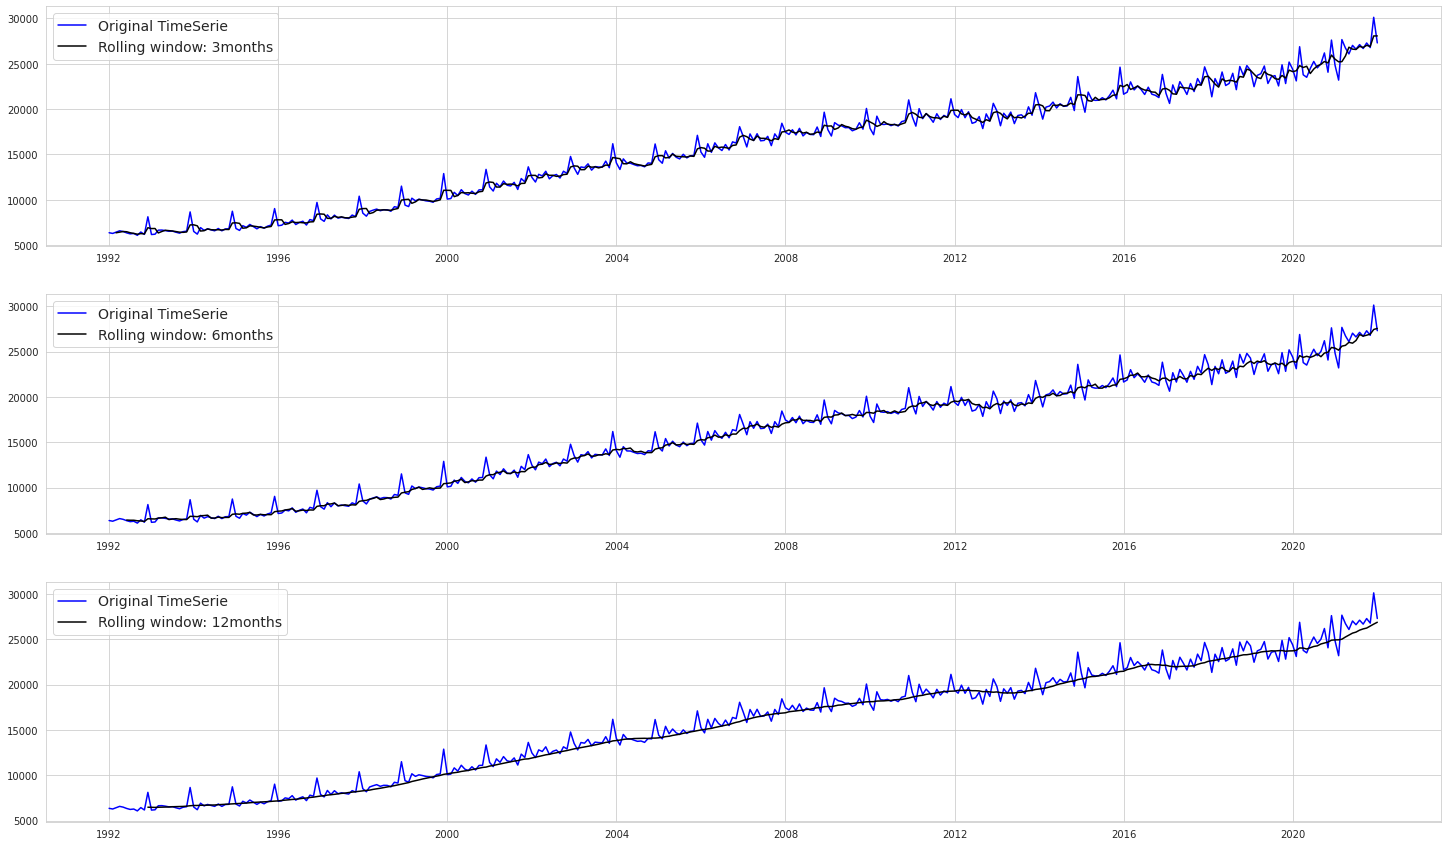

In [23]:
# Let's define a few rolling windows with diffenerent length
N_window =[3,6,12]

# Plotting the effect of different rolling MA windows
fig, axes = plt.subplots(len(N_window), 1, figsize=(25, 15))
for i in range(len(N_window)):
    axes[i].plot(data, color="blue")
    axes[i].plot(data.rolling(window = N_window[i]).mean(), color="black")
    # axes[i].plot(data.ewm(span = N_window[i]).mean(), color="black")    
    axes[i].legend(["Original TimeSerie", f"Rolling window: {N_window[i]}months"], prop={"size":14})

###  The residuals between the original TimeSerie and the rolling moving averaged TimeSerie can now be checked again stationarity

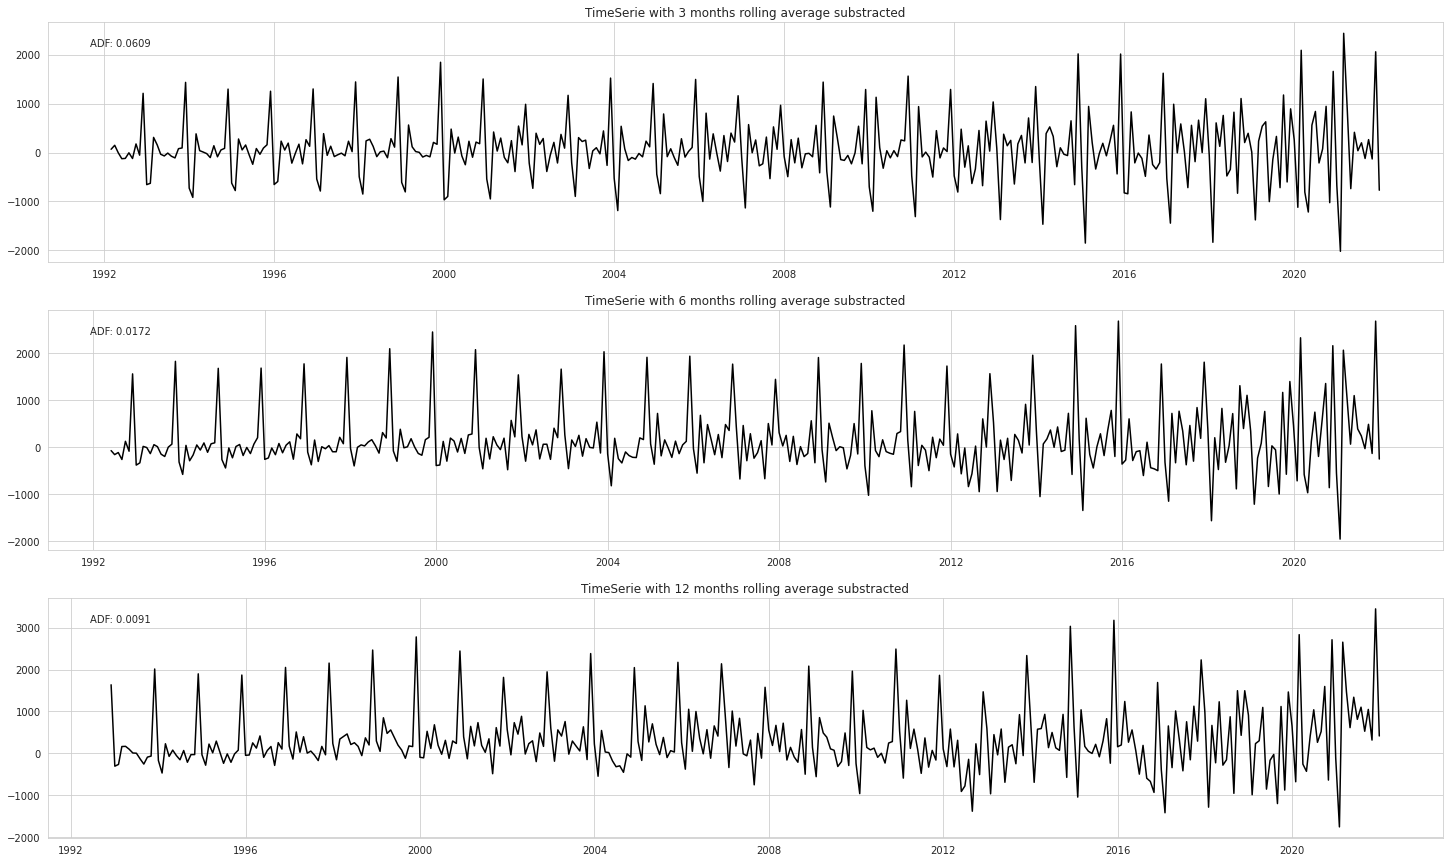

In [24]:
# Plotting the residuals between the original TimeSerie and the rolling moving averaged TimeSerie
fig, axes = plt.subplots(len(N_window), 1, figsize=(25, 15))
for i in range(len(N_window)):
    tmp_data = data - data.rolling(window = N_window[i]).mean()
    axes[i].plot(tmp_data, color="black")
    axes[i].text(x=.03, y=.9, s=f'ADF: {adfuller(tmp_data.dropna())[1]:.4f}', transform=axes[i].transAxes)
    axes[i].title.set_text(f"TimeSerie with {N_window[i]} months rolling average substracted")

## Option 4: Model the TimeSerie using an ARIMA model
### Option 4 step 1: Let's again split the TimeSerie dataset and fit an ARIMA model on the training data
... but this time we'll fit an ARIMA model directly on the TimeSerie data (not the decomposed data).

In [25]:
# Split the data into training and test sets
TEST_SIZE = 12
train, test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]

# Create and fit an ARIMA model with order(12,1,12) as we know we have yearly seasonality
ARIMA_model = ARIMA(train, order=(12,0,12), trend='ct')    
ARIMA_model_fit = ARIMA_model.fit()

print (ARIMA_model)
print (ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         MRTSSM44611USN   No. Observations:                  349
Model:               ARIMA(12, 0, 12)   Log Likelihood               -2564.256
Date:                Mon, 25 Jul 2022   AIC                           5182.512
Time:                        20:45:22   BIC                           5286.599
Sample:                    01-01-1992   HQIC                          5223.947
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5280.8576   1226.640      4.305      0.000    2876.688    7685.027
x1            57.4399      4.324     13.283      0.000      48.964      65.915
ar.L1         -0.0654      0.031     -2.087      0.0

Comments: 
- Below a few results of manual iterations,    
  - No trend, order=(3,1,3)   AIC 5600 MAPE 3.8%   
  - No trend, order=(6,1,6)   AIC 5463 MAPE 3.7%   
  - No trend, order=(12,1,12) AIC 5211 MAPE 2.5%   
  - No trend, order=(12,3,12) AIC 5300 MAPE 3.6%   
  - Trend="ct", order=(12,1,12) AIC 5182 MAPE 1.8%    
 
 
- the best model seems to have an order of (12,1,12) with linear+constant trend.

Let's check the fitness of our model vs the training data

MAPE 0.018525973581486672
MAE 258.60856780977707
RMSE:  377.42072014964566


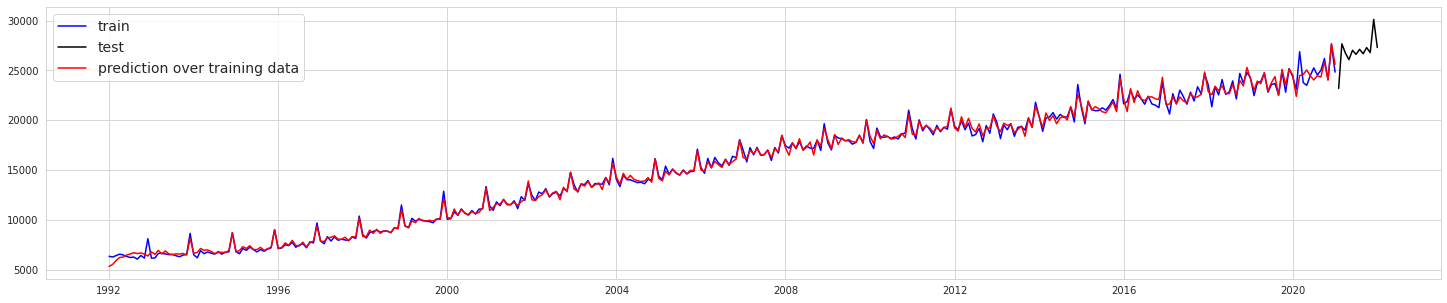

In [26]:
## In-sample prediction (on training data)
ARIMA_model_prediction = ARIMA_model_fit.predict(start=train[:1].index.format()[0], end=train[-1:].index.format()[0]) # works

print("MAPE",mean_absolute_percentage_error(train, ARIMA_model_prediction))
print("MAE",mean_absolute_error(train, ARIMA_model_prediction))
print("RMSE: ",(mean_squared_error(train, ARIMA_model_prediction))**0.5)

fig, ax1 = plt.subplots(1, 1, figsize=(25, 5))
ax1.plot(train, color="blue")
ax1.plot(test, color="black")
ax1.plot(ARIMA_model_prediction, color="red")
# ax1.fill_between(ARIMA_model_prediction.index, cf[0], cf[1],color='grey',alpha=.3)
ax1.legend(["train", "test", "prediction over training data"], prop={"size":14})

Comments:   
- The ARIMA model of order (12,0,12) with linear trend manages to capture fairly well the original TimeSerie including the spikes of the seasonality component.   .  
- Note that even though the integrated part was set to 0, the "trend" parameter ensures the model accounts for a linear trend with an intercept. 


Next, we should check the ACF & PACF of the model.   
Since the ARIMA model has a trend component we will take the 1st difference of the TimeSerie.

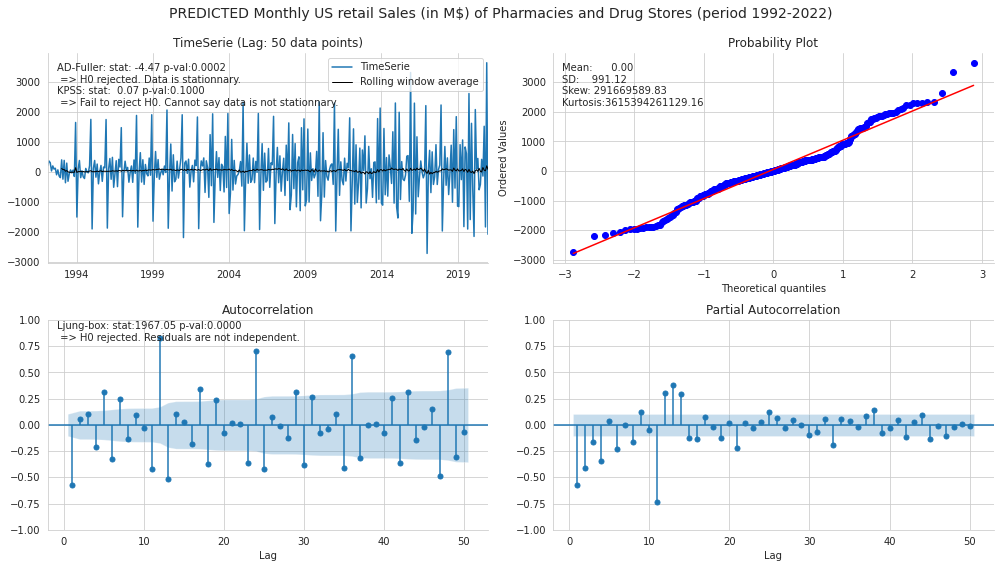

In [27]:
plot_correlogram(ARIMA_model_prediction.diff().dropna(), lags=50, title="PREDICTED "+stock_name)

Comments:   
- As expected the 1st difference of the TimeSerie is stationnary and both the ACF & PACF show some contributions similar to the original TimeSerie. 
- Note that the seasonal component is clearly visible on the 1st order difference. Seasonality is why we need a high order model.   
- The ARIMA model is not meant to capture seasonality instead one should use the SARIMAX model.    

### Option 4 step 2: Let's finally make a forecast using the ARIMA model

<class 'pandas.core.series.Series'>
(18,)


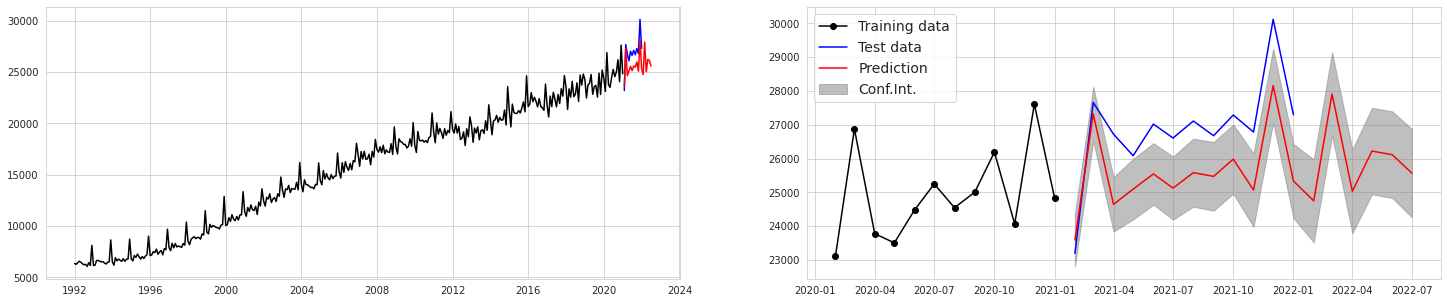

In [28]:
# Forecasting
ARIMA_model_prediction = ARIMA_model_fit.forecast(TEST_SIZE+6) # works
cf = ARIMA_model_fit.get_forecast(TEST_SIZE+6).conf_int(alpha=0.05)
print(type(cf.iloc[:, 0]))
print(ARIMA_model_prediction.shape)

# Plotting forecast and confidence interval 
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(25, 5))
ax1.plot(train, color="black")
ax1.plot(test, color="blue")
ax1.plot(ARIMA_model_prediction, color="red")

ax2.legend(["Training data", "Test data", "Prediction", "Conf.Int."], prop={"size":14})
ax2.plot(train[-12:], color="black", marker = 'o')
ax2.plot(test, color="blue")
ax2.plot(ARIMA_model_prediction, color="red")
ax2.fill_between(cf.index, cf.iloc[:, 0], cf.iloc[:, 1], color='grey', alpha=.5)
ax2.legend(["Training data", "Test data", "Prediction", "Conf.Int."], prop={"size":14})

Comments:   
- Although not bad it seems the ARIMA model made a prediction on the test data slightly off.   
- This is presumably because the model did not capture a slight change of trend between the training data and the test data.   
- Very interesting comparison relative to option 1 (decomposition prior to forecasting) where the trend was model over the last 12 months only.  

## Option 5: Model TimeSerie with an AUTO-ARIMA model 
### Option 5 step 1: Split the TimeSerie, then search for the best model

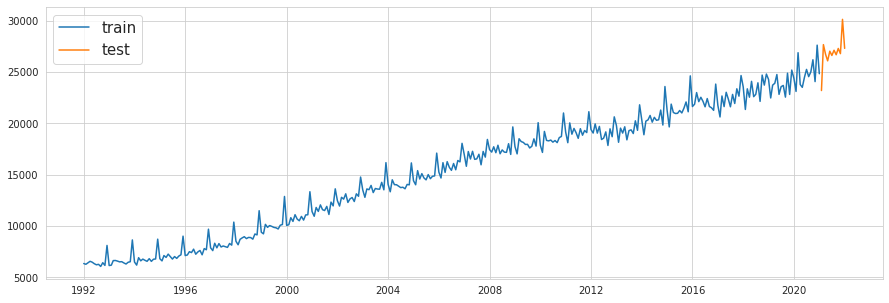

In [29]:
# Split the TimeSerie data into train & test dataset for later comparison when forecasting.
TEST_SIZE = 12 

train, test = data.iloc[:-TEST_SIZE], data.iloc[-TEST_SIZE:]
# x_train, x_test = np.array(range(train.shape[0])), np.array(range(train.shape[0], data.shape[0]))

# Plot datasets
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(train)
ax.plot(test)
ax.legend(['train', 'test'], prop={'size': 15})

In [30]:
# Search for the best model
# Note: SARIMAX = ARIMA(p,d,q)(P,D,Q)m
auto_arima_model = auto_arima( train,
                            start_p=0, max_p=12,             # starting and Max values for the AR model
                            start_q=0, max_q=12,             # starting and Max values for the MA model
                            d=1, max_d=2,                   # order (resp.c Max.) of first-differencing
                            test='adf',                     # test. default is "kpss"

                            with_intercept=True,            # If with_intercept is True, trend will be used. If with_intercept is False, the trend will be set to a no-intercept value. 
                            # trend="ct",                     # Trend parameter "ct", "c", "t"
                            seasonal=True,                  # Whether to fit a seasonal ARIMA
                            start_P=0, max_P=12,             # starting and Max values for the AR model of the seasonal component
                            start_Q=0, max_Q=12,             # starting and Max values for the AR model of the seasonal component
                            D=1, max_D=2,                   # order (resp.c Max.) of seasonal first-differencing
                            seasonal_test='oscb',           # Seasonal test
                            m=12,                           # period for seasonal differencing

                            max_order=50,                   # Maximum value of p+q+P+Q 
                            # start_params=(1,1),
                            returns_valid_fits=True,        # Whether method should validate results
                            out_of_sample_size= 0,          #  fit only a portion of the data if specified, in order to retain an “out of bag” sample score (already done with the TEST_SIZE)
                            score="mse",                    # Scoring: mse, mape, ame
                            information_criterion='aicc',    # 'aic', 'aicc', 'bic', 'hqic', 'oob'
                            stationary=False,               # Whether the time-series is stationary and d should be set to zero.
                            trace=True,                     # Print status of iterations
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True,                  # stepwise algorithm for optimal model parameters identification (FASTER)
                            n_jobs = 1,                     # number of models to fit in parallel in the case of a grid search (stepwise=False)
                            method ='lbfgs',                # solver from scipy.optimize (‘newton’, ‘nm’, ‘bfgs’, ‘powell’, ‘cg’, ‘ncg’, ‘basinhopping’, default: ‘lbfgs’)
                            )

print(f"Best model found: {auto_arima_model}")

Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AICC=5243.043, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12] intercept   : AICC=5158.777, Time=0.38 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AICC=5025.006, Time=1.03 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AICC=5241.023, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AICC=5088.456, Time=0.31 sec
 ARIMA(0,1,1)(1,1,1)[12] intercept   : AICC=5012.857, Time=1.46 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AICC=5082.927, Time=0.82 sec
 ARIMA(0,1,1)(2,1,1)[12] intercept   : AICC=4986.433, Time=3.07 sec
 ARIMA(0,1,1)(2,1,0)[12] intercept   : AICC=5055.857, Time=2.55 sec
 ARIMA(0,1,1)(3,1,1)[12] intercept   : AICC=4965.772, Time=5.87 sec
 ARIMA(0,1,1)(3,1,0)[12] intercept   : AICC=5012.951, Time=4.33 sec
 ARIMA(0,1,1)(4,1,1)[12] intercept   : AICC=4946.908, Time=11.72 sec
 ARIMA(0,1,1)(4,1,0)[12] intercept   : AICC=4951.719, Time=10.61 sec
 ARIMA(0,1,1)(5,1,1)[12] intercept   : AICC=inf, Time=23.14 sec
 ARIMA

Alternatively, load the saved model (manual step)...

In [31]:
# filename = 'auto_arima_model_(3,0,5)(0,1,1,12).pkl'
# filename = 'auto_arima_model_(1,0,1)(2,1,3,12).pkl'
# filename = 'auto_arima_model_(4,0,0)(0,1,2,12).pkl'
#
# object = []
# with (open(filename, "rb")) as openfile:
#     while True:
#         try:
#             object.append(pickle.load(openfile))
#         except EOFError:
#             break

# print(f"Model loaded: {auto_arima_model}")

# auto_arima_model = object[0]

### Option 5 step 2: Let's print the model characteristics and save it

In [32]:
# Let's print some of the model characteristics
print(auto_arima_model)
print(auto_arima_model.summary())

# model_params = auto_arima_model.get_params()
# print("Model parameters:")
# [print("  "+key+":",val) for key, val in model_params.items()] 

# auto_arima_model.plot_diagnostics(figsize=(15,7))
# plt.show()


 ARIMA(0,1,1)(5,1,0)[12]          
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  349
Model:             SARIMAX(0, 1, 1)x(5, 1, [], 12)   Log Likelihood               -2465.230
Date:                             Mon, 25 Jul 2022   AIC                           4944.460
Time:                                     20:52:51   BIC                           4971.179
Sample:                                          0   HQIC                          4955.111
                                             - 349                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6368      0.028    -23.071      0.000      -0.691     

Comments:   


### Option 5 step 3: save the model

In [33]:
# Save the model
model_params = auto_arima_model.get_params()
# print(model_params)
order = str(model_params['order'])
seasonal_order = str(model_params['seasonal_order'])
filename = ('auto_arima_model_'+order+seasonal_order+'.pkl').replace(" ", "")

with open(filename, 'wb') as pkl:
    pickle.dump(auto_arima_model, pkl)

print (f"Model {filename} saved.")

Model auto_arima_model_(0,1,1)(5,1,0,12).pkl saved.


### Option 5 step 4: Make an in-sample priction over the training dataset

MAPE 0.022843486189718782
MAE 290.9266812654866
RMSE:  576.783327439262


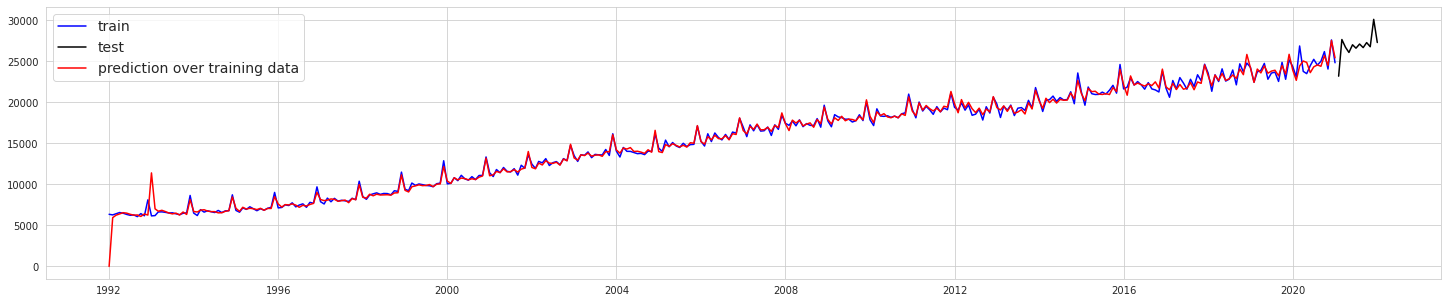

In [34]:
## In-sample prediction (on training data)
auto_arima_model_prediction = pd.Series(auto_arima_model.predict_in_sample(), index=train.index)

print("MAPE",mean_absolute_percentage_error(train, auto_arima_model_prediction))
print("MAE",mean_absolute_error(train, auto_arima_model_prediction))
print("RMSE: ",(mean_squared_error(train, auto_arima_model_prediction))**0.5)

fig, ax1 = plt.subplots(1, 1, figsize=(25, 5))
ax1.plot(train, color="blue")
ax1.plot(test, color="black")
ax1.plot(auto_arima_model_prediction, color="red")
ax1.legend(["train", "test", "prediction over training data"], prop={"size":14})

Comments:   
- The autoArima function is very handy and very powerful but also very sensitive to input parameters.  
- Many combination of parameters are possible and would yield a slightly different model order.   
- The above model is one amongst many options tried and was deemed as acceptable for the purpose of the project (and given timeline and available computing resources).   
- The model successfully captures TimeSerie trend and seasonality

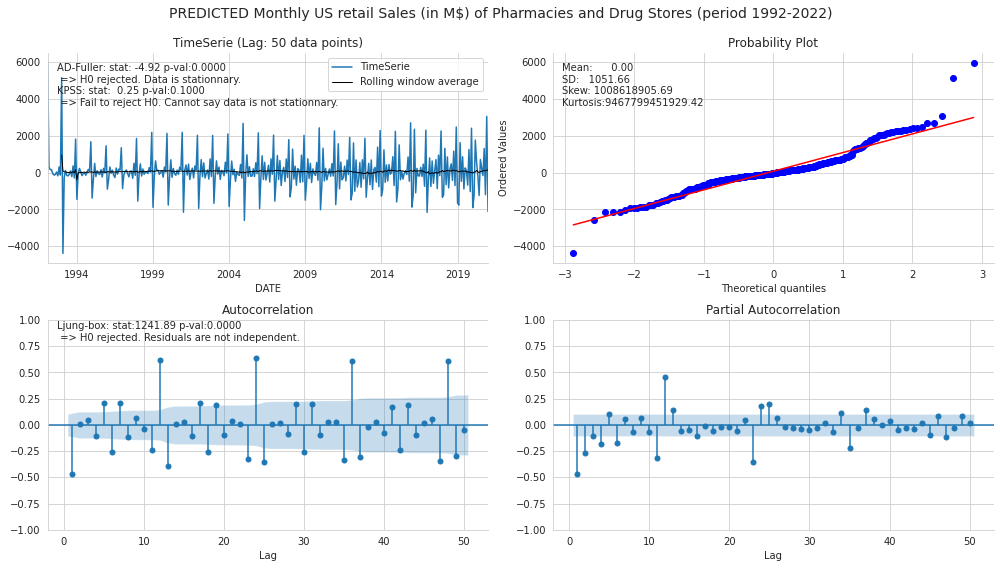

In [35]:
plot_correlogram(auto_arima_model_prediction.diff().dropna(), lags=50, title="PREDICTED "+stock_name)

### Option 5 step 4: Forecasting (naive approach)

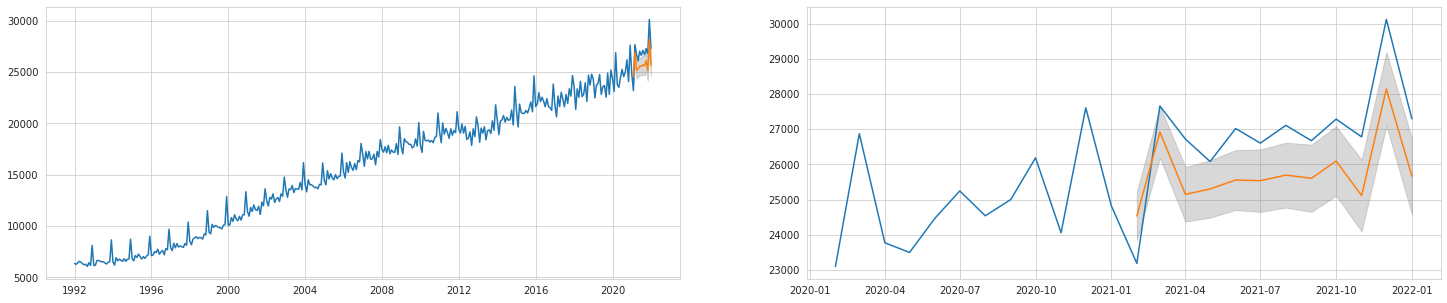

In [36]:
##Forecasting
prediction, confint = auto_arima_model.predict(n_periods=TEST_SIZE, return_conf_int=True)
cf= pd.DataFrame(confint)

prediction_series = pd.Series(prediction,index=test.index)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(25, 5))
ax1.plot(data)
ax1.plot(prediction_series)
ax1.fill_between(prediction_series.index, cf[0], cf[1],color='grey',alpha=.3)
ax2.plot(data[-24:])
ax2.plot(prediction_series)
ax2.fill_between(prediction_series.index, cf[0], cf[1],color='grey',alpha=.3)

Comments:  
- Similarly to past methods the forecast suseemssuccessfully captured the TimeSerie behaviour but with an slight offset trend.  
- It is believed that the latest months of the TimeSerie do feture a trend that is somewhat different than the rest of the TimeSerie (as illustrated in option1 above).   
- Nonetheless the auto ARIMA is very powerful and easy to use "out of the box" but one has to pay attention to the parameters used and validate the retained model. 

### Option 5 step 5: Forecasting (iterative approach)
TimeSerie model are usually very good at forecasting short term evolutions but their predictions tend to flaten out and converge to zero.   
The smaller the order of the model the quicker the model forecast will degrade.   
Basically the model confidence will divergence the farther the forecast in time.   
This is why finantial institutions only make a forecast a few months ahead then re-evaluate their model once new data is available.

We will now attempt to illustrate this behaviour, but we will use aSARIMAX modelrather than the Auto-Arima model (just for convenience). 

In [37]:
# Fit an SARIMAX model using the same model as the autoARIMA model i.e with order (0,1,1)(7,1,3,12).
sarimax_model = SARIMAX(train, order=(0,1,1), seasonal_order=(7, 1, 3, 12))
sarimax_model_fitted = sarimax_model.fit()

sarimax_model_fitted.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.33227D+00    |proj g|=  2.97022D-01


 This problem is unconstrained.



At iterate    5    f=  7.16226D+00    |proj g|=  9.54053D-03

At iterate   10    f=  7.16159D+00    |proj g|=  1.67712D-03

At iterate   15    f=  7.16111D+00    |proj g|=  1.93228D-02

At iterate   20    f=  7.15983D+00    |proj g|=  3.52885D-02

At iterate   25    f=  7.15712D+00    |proj g|=  2.10902D-02

At iterate   30    f=  7.15634D+00    |proj g|=  5.09536D-03

At iterate   35    f=  7.15605D+00    |proj g|=  1.93622D-03

At iterate   40    f=  7.15599D+00    |proj g|=  2.05387D-03

At iterate   45    f=  7.15256D+00    |proj g|=  2.77997D-02

At iterate   50    f=  7.11276D+00    |proj g|=  1.57217D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                             MRTSSM44611USN   No. Observations:                  349
Model:             SARIMAX(0, 1, 1)x(7, 1, [1, 2, 3], 12)   Log Likelihood               -2482.354
Date:                                    Mon, 25 Jul 2022   AIC                           4988.708
Time:                                            20:54:09   BIC                           5034.513
Sample:                                        01-01-1992   HQIC                          5006.967
                                             - 01-01-2021                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5908      0.041    -14.471      0.000      -0.671      -0.511
ar.S.L12      -0.5969      0.640     -0.932      0.351      -1.852       0.658
ar.S.L24      -0.0904      0.597     -0.151      0.880      -1.261       1.080
ar.S.L36      -0.8370      0.651     -1.285      0.199      -2.114       0.440
ar.S.L48      -0.4392      0.597     -0.736      0.462      -1.609       0.731
ar.S.L60      -0.0118      0.493     -0.024      0.981      -0.977       0.954
ar.S.L72      -0.0192      0.405     -0.048      0.962      -0.812       0.774
ar.S.L84       0.0449      0.229      0.196      0.845      -0.404       0.494
ma.S.L12      -0.0986      0.655     -0.151      0.880      -1.382       1.185
ma.S.L24      -0.4229      0.699     -0.605      0.545      -1.792       0.946
ma.S.L36       0.5008      0.519      0.964      0.335      -0.517       1.518
sigma2      1.801e+05   1.53e+04     11.751      0.000     1.5e+05     2.1e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.22   Jarque-Bera (JB):               712.29
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               5.63   Skew:                             0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Let's now plot an in-sample prediction

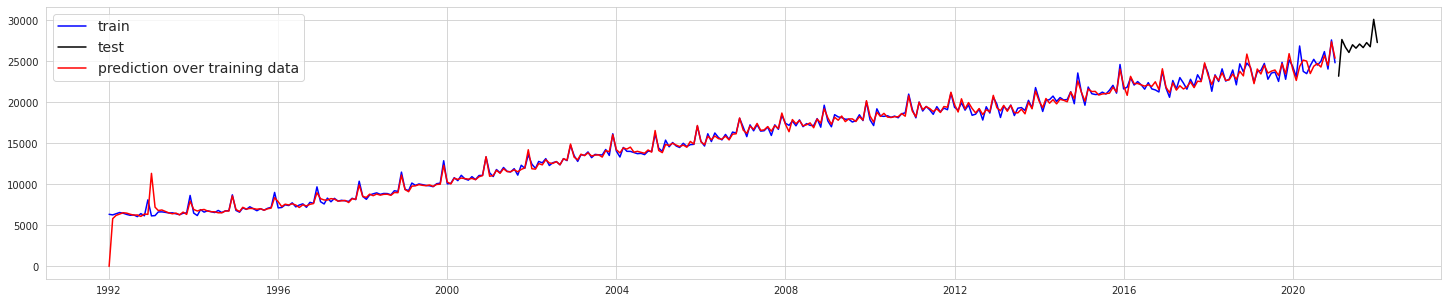

In [38]:
# Let's plot the in-sample prediction (i.e for the training data)
sarimax_model_fitted_prediction = sarimax_model_fitted.predict(start=train[:1].index.format()[0], end=train[-1:].index.format()[0]) # works

fig, ax1 = plt.subplots(1, 1, figsize=(25, 5))
ax1.plot(train, color="blue")
ax1.plot(test, color="black")
ax1.plot(sarimax_model_fitted_prediction, color="red")
ax1.legend(["train", "test", "prediction over training data"], prop={"size":14})

Let's now proceed and implement a rolling forecast, that is, make a shot term predicitions, refit the model, iteratively.. 

In [39]:
# Initialize rolling TimeSerie and Confidence intervals
rolling_prediction = test.copy()
rolling_cf_low = test.copy()
rolling_cf_high = test.copy()

for train_end in test.index:
    
    train_data = data[:train_end-timedelta(days=1)]
    
    model =  SARIMAX(train_data, order=(0,1,1), seasonal_order=(7, 1, 3, 12))
    model_fitted = model.fit()
    
    model_fitted_fcast = model_fitted.get_forecast()
    model_fitted_pred = model_fitted_fcast.predicted_mean
    cf = model_fitted_fcast.conf_int()
    
    rolling_prediction[train_end] = model_fitted_pred
    rolling_cf_low[train_end] = cf.iloc[0,0]
    rolling_cf_high[train_end] = cf.iloc[0,1]
    
    print(train_end, "prediction:", rolling_prediction[train_end])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.33227D+00    |proj g|=  2.97022D-01


 This problem is unconstrained.



At iterate    5    f=  7.16226D+00    |proj g|=  9.54053D-03

At iterate   10    f=  7.16159D+00    |proj g|=  1.67712D-03

At iterate   15    f=  7.16111D+00    |proj g|=  1.93228D-02

At iterate   20    f=  7.15983D+00    |proj g|=  3.52885D-02

At iterate   25    f=  7.15712D+00    |proj g|=  2.10902D-02

At iterate   30    f=  7.15634D+00    |proj g|=  5.09536D-03

At iterate   35    f=  7.15605D+00    |proj g|=  1.93622D-03

At iterate   40    f=  7.15599D+00    |proj g|=  2.05387D-03

At iterate   45    f=  7.15256D+00    |proj g|=  2.77997D-02

At iterate   50    f=  7.11276D+00    |proj g|=  1.57217D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.17571D+00    |proj g|=  8.88216D-03

At iterate   10    f=  7.17498D+00    |proj g|=  3.98976D-03

At iterate   15    f=  7.17369D+00    |proj g|=  1.46957D-02

At iterate   20    f=  7.17110D+00    |proj g|=  3.63920D-02

At iterate   25    f=  7.16928D+00    |proj g|=  5.08840D-03

At iterate   30    f=  7.16889D+00    |proj g|=  3.16219D-03

At iterate   35    f=  7.16882D+00    |proj g|=  1.44796D-03

At iterate   40    f=  7.16878D+00    |proj g|=  3.29019D-03

At iterate   45    f=  7.16690D+00    |proj g|=  2.46620D-02

At iterate   50    f=  7.16404D+00    |proj g|=  3.25835D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.17855D+00    |proj g|=  2.44540D-02

At iterate   10    f=  7.17757D+00    |proj g|=  3.16445D-03

At iterate   15    f=  7.17543D+00    |proj g|=  1.26938D-02

At iterate   20    f=  7.17285D+00    |proj g|=  3.95428D-02

At iterate   25    f=  7.17161D+00    |proj g|=  1.05032D-02

At iterate   30    f=  7.17113D+00    |proj g|=  2.62301D-03

At iterate   35    f=  7.17104D+00    |proj g|=  9.26901D-04

At iterate   40    f=  7.17072D+00    |proj g|=  7.28755D-03

At iterate   45    f=  7.16261D+00    |proj g|=  2.98295D-02

At iterate   50    f=  7.15970D+00    |proj g|=  8.87443D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.20175D+00    |proj g|=  1.10355D-02

At iterate   10    f=  7.20106D+00    |proj g|=  3.84139D-03

At iterate   15    f=  7.19972D+00    |proj g|=  2.83731D-02

At iterate   20    f=  7.19629D+00    |proj g|=  1.55449D-02

At iterate   25    f=  7.19404D+00    |proj g|=  2.72893D-02

At iterate   30    f=  7.19356D+00    |proj g|=  1.99251D-03

At iterate   35    f=  7.19352D+00    |proj g|=  3.95334D-03

At iterate   40    f=  7.19314D+00    |proj g|=  7.51030D-03

At iterate   45    f=  7.19094D+00    |proj g|=  2.70962D-02

At iterate   50    f=  7.19026D+00    |proj g|=  8.10243D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.20440D+00    |proj g|=  1.21340D-02

At iterate   10    f=  7.20373D+00    |proj g|=  5.97018D-03

At iterate   15    f=  7.20194D+00    |proj g|=  1.06507D-02

At iterate   20    f=  7.19931D+00    |proj g|=  1.19860D-02

At iterate   25    f=  7.19708D+00    |proj g|=  1.27942D-02

At iterate   30    f=  7.19648D+00    |proj g|=  4.71258D-03

At iterate   35    f=  7.19640D+00    |proj g|=  3.47566D-03

At iterate   40    f=  7.19635D+00    |proj g|=  5.02377D-03

At iterate   45    f=  7.19520D+00    |proj g|=  1.74741D-02

At iterate   50    f=  7.19386D+00    |proj g|=  7.13066D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.20656D+00    |proj g|=  1.50314D-02

At iterate   10    f=  7.20535D+00    |proj g|=  8.37083D-03

At iterate   15    f=  7.20357D+00    |proj g|=  1.32909D-02

At iterate   20    f=  7.19999D+00    |proj g|=  1.23944D-02

At iterate   25    f=  7.19837D+00    |proj g|=  1.30858D-02

At iterate   30    f=  7.19804D+00    |proj g|=  2.12135D-03

At iterate   35    f=  7.19798D+00    |proj g|=  4.42814D-03

At iterate   40    f=  7.19738D+00    |proj g|=  6.51289D-03

At iterate   45    f=  7.19635D+00    |proj g|=  8.70917D-03

At iterate   50    f=  7.19569D+00    |proj g|=  7.91177D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.20620D+00    |proj g|=  1.33699D-02

At iterate   10    f=  7.20519D+00    |proj g|=  7.32257D-03

At iterate   15    f=  7.20349D+00    |proj g|=  6.18756D-03

At iterate   20    f=  7.20096D+00    |proj g|=  5.57560D-02

At iterate   25    f=  7.19839D+00    |proj g|=  1.48436D-02

At iterate   30    f=  7.19780D+00    |proj g|=  2.84044D-03

At iterate   35    f=  7.19771D+00    |proj g|=  9.05600D-04

At iterate   40    f=  7.19761D+00    |proj g|=  3.70235D-03

At iterate   45    f=  7.19584D+00    |proj g|=  1.37088D-02

At iterate   50    f=  7.19495D+00    |proj g|=  4.05618D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.20634D+00    |proj g|=  1.35610D-02

At iterate   10    f=  7.20546D+00    |proj g|=  8.09849D-03

At iterate   15    f=  7.20273D+00    |proj g|=  2.48460D-02

At iterate   20    f=  7.20013D+00    |proj g|=  2.41701D-02

At iterate   25    f=  7.19847D+00    |proj g|=  2.29528D-02

At iterate   30    f=  7.19794D+00    |proj g|=  3.53602D-03

At iterate   35    f=  7.19788D+00    |proj g|=  1.24408D-03

At iterate   40    f=  7.19769D+00    |proj g|=  1.12555D-02

At iterate   45    f=  7.19519D+00    |proj g|=  7.92549D-03

At iterate   50    f=  7.19433D+00    |proj g|=  2.28431D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.20556D+00    |proj g|=  1.09558D-02

At iterate   10    f=  7.20461D+00    |proj g|=  6.31149D-03

At iterate   15    f=  7.20201D+00    |proj g|=  1.87444D-02

At iterate   20    f=  7.19878D+00    |proj g|=  1.70474D-02

At iterate   25    f=  7.19722D+00    |proj g|=  3.33615D-03

At iterate   30    f=  7.19708D+00    |proj g|=  1.13188D-03

At iterate   35    f=  7.19702D+00    |proj g|=  2.45947D-03

At iterate   40    f=  7.19668D+00    |proj g|=  1.45696D-02

At iterate   45    f=  7.19593D+00    |proj g|=  6.83013D-03

At iterate   50    f=  7.19532D+00    |proj g|=  5.09942D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.20851D+00    |proj g|=  9.36261D-03

At iterate   10    f=  7.20718D+00    |proj g|=  1.09275D-02

At iterate   15    f=  7.20523D+00    |proj g|=  2.80885D-02

At iterate   20    f=  7.20163D+00    |proj g|=  2.48472D-02

At iterate   25    f=  7.20069D+00    |proj g|=  4.35114D-03

At iterate   30    f=  7.20019D+00    |proj g|=  2.03549D-03

At iterate   35    f=  7.20014D+00    |proj g|=  1.59008D-03

At iterate   40    f=  7.19964D+00    |proj g|=  1.44347D-02

At iterate   45    f=  7.19865D+00    |proj g|=  5.53006D-03

At iterate   50    f=  7.19819D+00    |proj g|=  4.34537D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.21403D+00    |proj g|=  1.15697D-02

At iterate   10    f=  7.21303D+00    |proj g|=  7.25413D-03

At iterate   15    f=  7.21063D+00    |proj g|=  1.61768D-02

At iterate   20    f=  7.20731D+00    |proj g|=  1.55802D-02

At iterate   25    f=  7.20589D+00    |proj g|=  4.10043D-03

At iterate   30    f=  7.20554D+00    |proj g|=  1.30471D-03

At iterate   35    f=  7.20550D+00    |proj g|=  2.22976D-03

At iterate   40    f=  7.20499D+00    |proj g|=  5.76196D-03

At iterate   45    f=  7.20272D+00    |proj g|=  1.45125D-02

At iterate   50    f=  7.19983D+00    |proj g|=  8.64706D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.21614D+00    |proj g|=  1.21627D-02

At iterate   10    f=  7.21525D+00    |proj g|=  5.94862D-03

At iterate   15    f=  7.21440D+00    |proj g|=  6.83241D-03

At iterate   20    f=  7.21025D+00    |proj g|=  2.92135D-02

At iterate   25    f=  7.20804D+00    |proj g|=  9.29069D-03

At iterate   30    f=  7.20752D+00    |proj g|=  1.57435D-03

At iterate   35    f=  7.20750D+00    |proj g|=  1.77067D-03

At iterate   40    f=  7.20724D+00    |proj g|=  1.10834D-02

At iterate   45    f=  7.20528D+00    |proj g|=  9.33575D-03

At iterate   50    f=  7.20401D+00    |proj g|=  8.80378D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

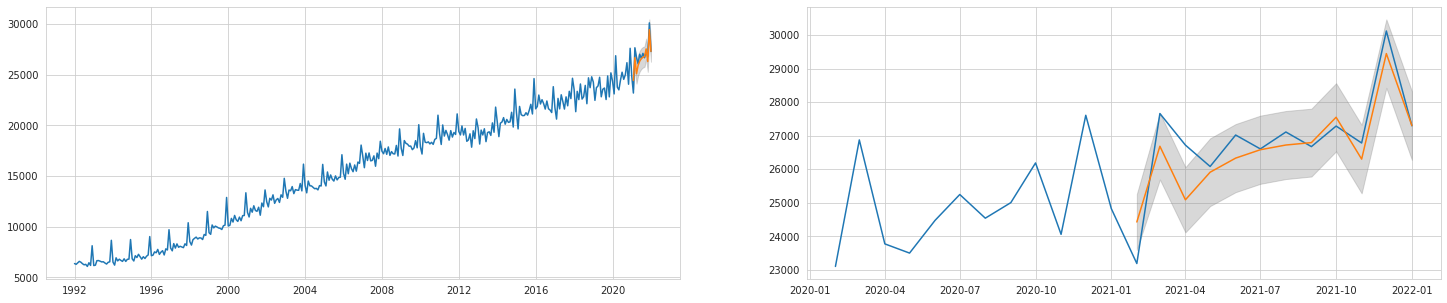

In [40]:
## Plotting rolling Forecast
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(25, 5))
ax1.plot(data)
ax1.plot(rolling_prediction)
ax1.fill_between(rolling_prediction.index, rolling_cf_low, rolling_cf_high, color='grey',alpha=.3)

ax2.plot(data[-24:])
ax2.plot(rolling_prediction)
ax2.fill_between(rolling_prediction.index, rolling_cf_low, rolling_cf_high, color='grey',alpha=.3)

Comments:   
- The difference compared to the "naive" forecast is striking.   
- The model is frequently updated with newly available data and incorporate data changes in the new short term forecast.  
- Making long term predictions is challenging and rolling forecast is currently preferred to limit variance of the predictions.  